In [1]:
from utils import *
from os import walk
from adjustText import adjust_text


# minimal promoter

In [370]:
path = 'activatable promoters/ecoli/promoter/p70mut/'
(_,_,filenames) = list(walk(path))[0]

In [371]:
read_OD = lambda f: pd.read_csv(path+f, delimiter  = '\t', skiprows = 52, index_col = (13,0)).loc['600'].set_index('Unnamed: 0')
OD = {f[:-4] : read_OD(f) for f in filenames if f[-3:] == 'txt'}

read_RFP= lambda f: pd.read_csv(path+f, delimiter  = '\t', skiprows = 52, index_col = (13,0)).loc['GFP+RFP:540/35,600/40'].set_index('Unnamed: 0').set_index(OD[f[:-4]].index)
RFP = {f[:-4] : read_RFP(f) for f in filenames if f[-3:] == 'txt'}

In [372]:
plate = pd.read_csv(path+'211103-S_LAYOUT.csv', index_col = 0, dtype = str) # reads plate layout

# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append((i[0], i[1]))
            
lib = [(r,c) for r in RFP['S_0'].index for c in RFP['S_0'].columns]

get_data = lambda X, df, lbl: np.array([df[lbl].loc[x] for x in X])
get_ratio = lambda X, lbl: get_data(X,RFP,lbl)/get_data(X,OD,lbl)

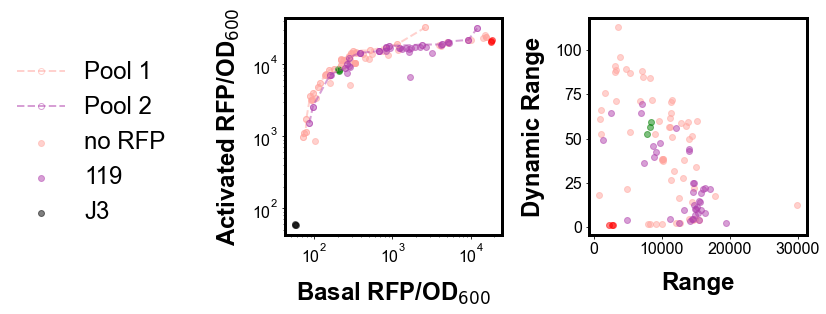

In [373]:

b0 = get_ratio(exps['J2'],'S_0')
b200 = get_ratio(exps['J2'],'S_200')

max0 = get_ratio(exps['119'],'S_0')
max200 = get_ratio(exps['119'],'S_200')

J30 = get_ratio(exps['J3'],'S_0')
J3200 = get_ratio(exps['J3'],'S_200')

S0 = get_ratio(exps['lib'],'S_0')
S200 = get_ratio(exps['lib'],'S_200')
B200 = get_ratio(lib,'B_200')
B0 = get_ratio(lib,'B_0')

R = lambda B,A: (A-b200.mean()) - (B-b0.mean())
DR = lambda B,A: (A-b200.mean()) / (B-b0.mean())

cutoff = 1.5

colors = ['#93003a', '#dd4c65', '#ffa59e', '#f08cef', '#b041ad', '#630065']

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(B0[DR(B0,B200)>cutoff],B200[DR(B0,B200)>cutoff], color= '#ffa59e', alpha = 0.5)
plt.scatter(S0[DR(S0,S200)>cutoff],S200[DR(S0,S200)>cutoff], color = '#b041ad', alpha = 0.5)
plt.scatter(b0,b200, color = 'k', alpha = 0.5)
plt.scatter(max0,max200, color = 'r', alpha = 0.5)
plt.scatter(J30,J3200, color = 'g', alpha = 0.5)

sort_idb = np.argsort(B0[DR(B0,B200)>cutoff][optB])
sort_ids = np.argsort(S0[DR(S0,S200)>cutoff][optS])
plt.plot(B0[DR(B0,B200)>cutoff][optB][sort_idb],B200[DR(B0,B200)>cutoff][optB][sort_idb], color= '#ffa59e', alpha = 0.5,marker = 'o', linestyle='--', markerfacecolor='none')
plt.plot(S0[DR(S0,S200)>cutoff][optS][sort_ids],S200[DR(S0,S200)>cutoff][optS][sort_ids], color = '#b041ad', alpha = 0.5,marker = 'o', linestyle='--',markerfacecolor='none')

plt.legend(['Pool 1','Pool 2','no RFP','119','J3'], frameon = False, bbox_to_anchor=(-0.45, .90),fontsize = 24)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Activated RFP/OD$_{600}$', labelpad = ypad, fontsize = 24)
plt.xlabel('Basal RFP/OD$_{600}$', labelpad = xpad, fontsize = 24)
plt.gca().set_aspect(1./plt.gca().get_data_ratio())


plt.subplot(122)
plt.scatter(R(B0,B200)[DR(B0,B200)>cutoff],DR(B0,B200)[DR(B0,B200)>cutoff], color= '#ffa59e', alpha = 0.5)
plt.scatter(R(S0,S200)[DR(S0,S200)>cutoff],DR(S0,S200)[DR(S0,S200)>cutoff], color= '#b041ad', alpha = 0.5)
plt.scatter(R(max0,max200),DR(max0,max200), color = 'r', alpha = 0.5)
plt.scatter(R(J30,J3200),DR(J30,J3200),color = 'g', alpha= 0.5)
#plt.legend(['Pool 1','Pool 2','119','J3'])

plt.ylabel('Dynamic Range', labelpad = ypad, fontsize = 24)
plt.xlabel('Range', labelpad = xpad, fontsize = 24)
plt.gca().set_aspect(1./plt.gca().get_data_ratio())

plt.savefig('promoter-screen.svg')

In [284]:
allR = np.array(list(R(B0,B200)[DR(B0,B200)>cutoff])+list(R(S0,S200)[DR(S0,S200)>cutoff]))
allDR = np.array(list(DR(B0,B200)[DR(B0,B200)>cutoff])+list(DR(S0,S200)[DR(S0,S200)>cutoff]))

bestR = np.argsort(allR)[-9:]
bestDR = np.argsort(allDR)[-9:]

In [303]:
allR.max()

29854.751734425256

In [286]:
np.std(allDR[bestDR].mean()/allDR[bestR])

9.354157210981176

In [289]:
allR[bestR].mean()/allR[bestDR].mean()

4.00542630201754

In [304]:
allR.max()/((J3200.mean()-b200.mean())-(J30.mean()-b0.mean()))

3.655914422516666

In [29]:
optB = pareto(B200[DR(B0,B200)>cutoff], B0[DR(B0,B200)>cutoff])
optS = pareto(S200[DR(S0,S200)>cutoff], S0[DR(S0,S200)>cutoff])
optT = pareto(list(S200[DR(S0,S200)>cutoff])+list(B200[DR(B0,B200)>cutoff]), list(S0[DR(S0,S200)>cutoff])+list(B0[DR(B0,B200)>cutoff]))

In [43]:
sum(optB)

21

In [44]:
sum(np.array(optT)*np.array((optS+optB)))/(sum(optB+optS))

0.6578947368421053

In [127]:
# for k,r in enumerate(DR(B0,B200)):
#     if r < 1.4:
#         print(k,lib[k])
        
# for k,r in enumerate(DR(S0,S200)):
#     if r < 1.4:
#         print(k,exps['lib'][k])

In [128]:
nB = lambda B: (B-b0.mean())/(J30.mean()-b0.mean())
nA = lambda A: (A-b200.mean())/(J3200.mean()-b200.mean())

In [129]:
rel_promoter_libs_0 = nB([*B0[DR(B0,B200)>cutoff],*S0[DR(S0,S200)>cutoff]])
rel_promoter_libs_200 = nB([*B200[DR(B0,B200)>cutoff],*S200[DR(S0,S200)>cutoff]])


old data from Ben

In [37]:
# ratios = {f[:-4]: pd.read_csv(p70path+f) for f in filenames if f[-3:] == 'csv'}

In [38]:
# plt.figure(figsize = (5,5))
# plt.scatter(ratios['p70mut'][ratios['p70mut']['label']=='S'].baseline,ratios['p70mut'][ratios['p70mut']['label']=='S'].activated)
# plt.scatter(ratios['p70mut'][ratios['p70mut']['label']=='B'].baseline,ratios['p70mut'][ratios['p70mut']['label']=='B'].activated)
# plt.scatter(ratios['pAP8'][ratios['pAP8']['label']=='pAP8'].basal,ratios['pAP8'][ratios['pAP8']['label']=='pAP8'].activated)

# plt.xscale('log')
# plt.yscale('log')
# plt.ylabel('Activated RFP/OD', labelpad = ypad)
# plt.xlabel('Basal RFP/OD', labelpad = xpad)
# plt.ylim(plt.gca().get_ylim())
# plt.gca().set_aspect(1./plt.gca().get_data_ratio())
# plt.xlim(plt.gca().get_xlim())


In [39]:
# plt.figure(figsize = (5,5))

# b = 50
# b1 = ratios['p70mut'][ratios['p70mut']['label']=='S'].baseline -b
# b2 = ratios['p70mut'][ratios['p70mut']['label']=='B'].baseline -b
# b3 = ratios['pAP8'][ratios['pAP8']['label']=='pAP8'].basal -b

# a1 = ratios['p70mut'][ratios['p70mut']['label']=='S'].activated -b
# a2 = ratios['p70mut'][ratios['p70mut']['label']=='B'].activated -b
# a3 = ratios['pAP8'][ratios['pAP8']['label']=='pAP8'].activated -b

# plt.scatter(a1-b1,a1/b1)
# plt.scatter(a2-b2,a2/b2)
# plt.scatter(a3-b3,a3/b3)

# plt.ylabel('Dynamic Range', labelpad = ypad)
# plt.xlabel('Range', labelpad = xpad)
# plt.ylim(plt.gca().get_ylim())
# plt.gca().set_aspect(1./plt.gca().get_data_ratio())
# plt.xlim(plt.gca().get_xlim())


In [7]:
pareto = lambda A, B: [~(np.any((A>a) & (B<b))) for a,b in zip(A,B)]

In [158]:
auto = 52
basal = ratios['pAP8'][ratios['pAP8']['label']=='pAP8'].basal - auto
activated = ratios['pAP8'][ratios['pAP8']['label']=='pAP8'].activated - auto

# auto = 54
# basal = ratios['p70mut'].baseline - auto
# activated = ratios['p70mut'].activated - auto

opt = pareto(activated, basal)
activated = activated[opt]
basal = basal[opt]

FC = activated / basal

from scipy.optimize import curve_fit, minimize
def Hill_ratio(basal,a,b,c,d):
    return (a*basal+c)/(b*basal**2+d)
#     ks = kfun(basal,c,z)
#     return (1/a)*(L**(na-nb))*(b*basal + L**nb)/(b*basal*ks+L**na)

def Hill_ratio_2(basal,a,b,L,c,z):
    C = kfun(basal,c,z)
    return (1/a)*(b*basal + L)/(C*b*basal+L)

def kfun(basal, a, b):
    return a*basal+b

def mylog(basal,a,b):
    return a*np.log(basal)+b


def cost(args,f,x,y):
    return np.nansum((f(x,*args)-y)**2,axis=0)

def Hill_ratio_2s(basal,z):
    A = z[:,1][:,np.newaxis]@basal + z[:,3][:,np.newaxis]
    B = z[:,2][:,np.newaxis]*z[:,1][:,np.newaxis]@basal + z[:,3][:,np.newaxis]
    return 1/z[:,0][:,np.newaxis] * A/B

def cost_s(args,f,x,y):
    return np.nansum((f(x,args)-y)**2,axis=1)

def cost_s2(args,f,x,y):
    return np.nansum(  [(f(x,*args[i,:])-y)**2 for i in range(args.shape[0])],axis=1)

In [257]:
import pyswarms as ps
options = {'c1': 0.5, 'c2': 0.5, 'w':0.9}
bounds = (np.array([0,]*4),np.array([1e5,]*4))
optimizer = ps.single.GlobalBestPSO(n_particles=5000, dimensions=4, options=options)
optimizer.optimize(cost_s, f = Hill_ratio_2s, x = basal[:,np.newaxis].T, y = FC[:,np.newaxis].T, iters = 1000)

C:\Users\Diego Alba\.conda\envs\txtl-sim\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """
2021-09-09 17:44:17,134 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|1000/1000, best_cost=1.23e+5
2021-09-09 17:44:22,549 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 123172.40300754968, best pos: [ 3.25532759e-03 -1.86490711e-03 -7.69287586e+00  1.29848896e+00]


(123172.40300754968,
 array([ 3.25532759e-03, -1.86490711e-03, -7.69287586e+00,  1.29848896e+00]))

In [255]:
bounds = (*((0,None),)*3,*((None, None),)*2)
minimize(cost, [2,2,2,2,2], args = (Hill_ratio_2, basal, FC), method='Nelder-Mead', bounds = bounds, tol = 1e-10, options = {'maxiter':100000})

C:\Users\Diego Alba\.conda\envs\txtl-sim\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


 final_simplex: (array([[1.51950771e-03, 9.21421083e+00, 0.00000000e+00, 3.15035612e-02,
        2.11081012e+00],
       [1.51950771e-03, 9.21421083e+00, 0.00000000e+00, 3.15035612e-02,
        2.11081012e+00],
       [1.51950771e-03, 9.21421083e+00, 0.00000000e+00, 3.15035612e-02,
        2.11081012e+00],
       [1.51950771e-03, 9.21421083e+00, 0.00000000e+00, 3.15035612e-02,
        2.11081012e+00],
       [1.51950771e-03, 9.21421083e+00, 0.00000000e+00, 3.15035612e-02,
        2.11081012e+00],
       [1.51950771e-03, 9.21421083e+00, 0.00000000e+00, 3.15035612e-02,
        2.11081012e+00]]), array([128342.53013237, 128342.53013237, 128342.53013237, 128342.53013237,
       128342.53013237, 128342.53013237]))
           fun: 128342.53013237195
       message: 'Optimization terminated successfully.'
          nfev: 716
           nit: 381
        status: 0
       success: True
             x: array([1.51950771e-03, 9.21421083e+00, 0.00000000e+00, 3.15035612e-02,
       2.11081012e+00])

In [159]:
bounds = ([0,0,0,0,-np.inf,-np.inf,-np.inf],[np.inf]*7)
fit = curve_fit(Hill_ratio, basal, FC, maxfev=90000)

bounds_2 = ([0,0,0,-np.inf,-np.inf],[np.inf]*5)
fit_2 = curve_fit(Hill_ratio_2, basal, FC, maxfev=90000)

log_fit = curve_fit(mylog, basal, activated)


In [137]:
fit

(array([-4.93722329e-03, -1.00844442e+01,  2.33777807e+01,  8.75523584e-01,
         1.19288662e+00, -1.67305555e-01,  1.00000000e+00]),
 array([[inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf],
        [inf, inf, inf, inf, inf, inf, inf]]))

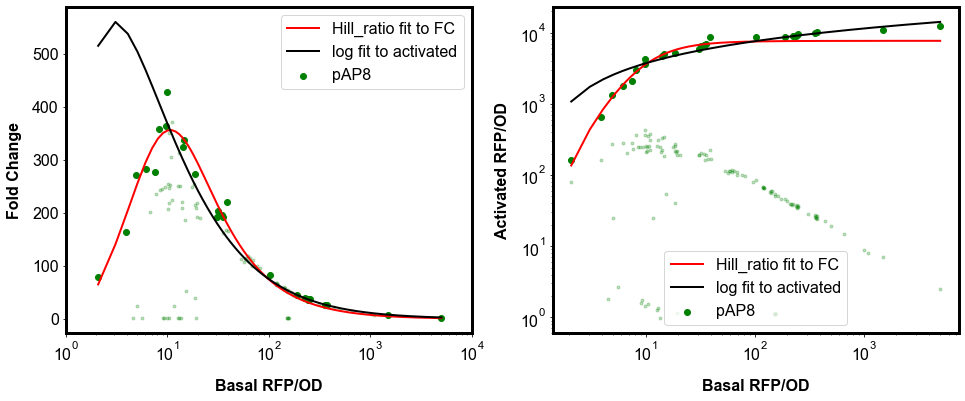

In [160]:
plt.figure(figsize=(16,6))
basal_hat = np.arange(basal.min(),basal.max())

plt.subplot(1,2,2)
plt.scatter(ratios['pAP8'].basal - auto, (ratios['pAP8'].activated - auto)/(ratios['pAP8'].basal - auto),color = 'g',marker='.', alpha = 0.25)

plt.scatter(basal, basal*FC, label = 'pAP8', color = 'g')
plt.plot(basal_hat, basal_hat*Hill_ratio(basal_hat,*fit[0]),'r', label = 'Hill_ratio fit to FC')
plt.plot(basal_hat, basal_hat*mylog(basal_hat,*log_fit[0])/basal_hat,'k', label = 'log fit to activated')

plt.xscale('log')
plt.yscale('log')

plt.ylabel('Activated RFP/OD', labelpad = ypad)
plt.xlabel('Basal RFP/OD', labelpad = xpad)
plt.legend()

plt.subplot(1,2,1)
plt.scatter(ratios['pAP8'].basal - auto, (ratios['pAP8'].activated - auto)/(ratios['pAP8'].basal - auto),color = 'g',marker='.', alpha = 0.25)

plt.scatter(basal, FC, label = 'pAP8', color = 'g')
plt.plot(basal_hat, Hill_ratio(basal_hat,*fit[0]),'r', label = 'Hill_ratio fit to FC')

plt.plot(basal_hat, mylog(basal_hat,*log_fit[0])/basal_hat,'k', label = 'log fit to activated')

plt.xscale('log')
plt.xlim([1e0,1e4])

plt.ylabel('Fold Change', labelpad = ypad)
plt.xlabel('Basal RFP/OD', labelpad = xpad)
plt.legend()

# UP element

In [305]:
UPpath = 'activatable promoters/ecoli/UP/'
(_,_,filenames) = list(walk(UPpath))[0]

In [306]:
read_OD = lambda f: pd.read_csv(UPpath+f, delimiter  = '\t', skiprows = 52, index_col = (13,0)).loc['600'].set_index('Unnamed: 0')
OD = {f[:-4] : read_OD(f) for f in filenames if f[-3:] == 'txt'}

read_RFP= lambda f: pd.read_csv(UPpath+f, delimiter  = '\t', skiprows = 52, index_col = (13,0)).loc['GFP+RFP:540/35,600/40'].set_index('Unnamed: 0').set_index(OD[f[:-4]].index)
RFP = {f[:-4] : read_RFP(f) for f in filenames if f[-3:] == 'txt'}

In [307]:
plate = pd.read_csv(UPpath+'210709-control_LAYOUT.csv', index_col = 0, dtype = str) # reads plate layout

# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append((i[0], i[1]))
            
lib = [(r,c) for r in RFP['control_0'].index for c in RFP['control_0'].columns]
libs = ['61','63','62','65','64','66']
lib_name = ['Strong','Reasonable','Random','Weak','Broken','Consensous']

In [308]:
get_data = lambda X, df, lbl: np.array([df[lbl].loc[x] for x in X])
get_all_data = lambda df, lbl: np.array([*get_data(lib,df,lbl), *get_data(exps[lbl[:2]],df,'control'+lbl[2:])])

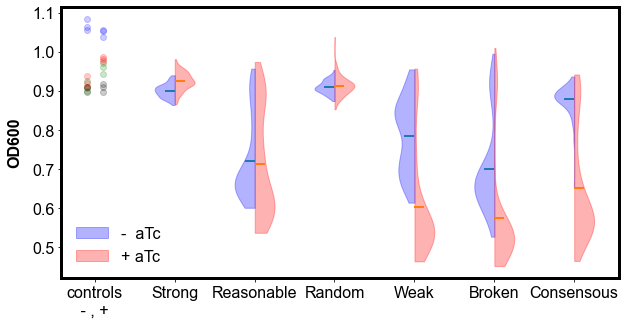

In [309]:
plt.figure(figsize=(10,5))
v1 = plt.violinplot([get_all_data(OD,l+'_0') for l in libs], showextrema=False, showmeans = True)
for k in range(0,len(libs)): v1['cmeans'].get_paths()[k].vertices[1,0] = k+1
v1['cmeans'].set_linewidth(2)

for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
    b.set_color('b')
    
v2 = plt.violinplot([get_all_data(OD,l+'_200') for l in libs], showextrema=False, showmeans = True)
#plt.yscale('log')
for k in range(0,len(libs)): v2['cmeans'].get_paths()[k].vertices[0,0] = k+1
v2['cmeans'].set_linewidth(2)


for b in v2['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further left than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')

plt.ylabel('OD600', labelpad = ypad)
plt.xticks([0,1,2,3,4,5,6],['controls\n - , + ',*lib_name])
plt.legend([v1['bodies'][0],v2['bodies'][0]], ['-  aTc', '+ aTc'], frameon = False, loc = 'lower left')

plt.scatter(3*[-0.1], get_data(exps['off'],OD,'control_0'), color = 'k', alpha = 0.2, label = 'off')
plt.scatter(3*[-0.1], get_data(exps['J3'],OD,'control_0'), color = 'g', alpha = 0.2, label = 'J3')
plt.scatter(3*[-0.1], get_data(exps['E'],OD,'control_0'), color = 'r', alpha = 0.2, label = 'E')
plt.scatter(3*[-0.1], get_data(exps['119'],OD,'control_0'), color = 'b', alpha = 0.2, label = 'max')


plt.scatter(3*[0.1], get_data(exps['off'],OD,'control_200'), color = 'k', alpha = 0.2, label = 'off')
plt.scatter(3*[0.1], get_data(exps['J3'],OD,'control_200'), color = 'g', alpha = 0.2, label = 'J3')
plt.scatter(3*[0.1], get_data(exps['E'],OD,'control_200'), color = 'r', alpha = 0.2, label = 'E')
plt.scatter(3*[0.1], get_data(exps['119'],OD,'control_200'), color = 'b', alpha = 0.2, label = 'max')

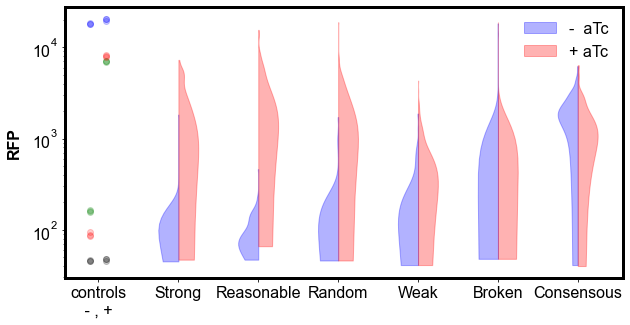

In [310]:
plt.figure(figsize=(10,5))
v1 = plt.violinplot([get_all_data(RFP,l+'_0') for l in libs], showextrema=False, showmeans = False)

for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
    b.set_color('b')
    
v2 = plt.violinplot([get_all_data(RFP,l+'_200') for l in libs], showextrema=False, showmeans = False)

for b in v2['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further left than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')

plt.ylabel('RFP', labelpad = ypad)
plt.xticks([0,1,2,3,4,5,6],['controls\n - , + ',*lib_name])
plt.legend([v1['bodies'][0],v2['bodies'][0]], ['-  aTc', '+ aTc'], frameon = False, loc = 'upper right')
plt.yscale('log')

plt.scatter(3*[-0.1], get_data(exps['off'],RFP,'control_0'), color = 'k', alpha = 0.2, label = 'off')
plt.scatter(3*[-0.1], get_data(exps['J3'],RFP,'control_0'), color = 'g', alpha = 0.2, label = 'J3')
plt.scatter(3*[-0.1], get_data(exps['E'],RFP,'control_0'), color = 'r', alpha = 0.2, label = 'E')
plt.scatter(3*[-0.1], get_data(exps['119'],RFP,'control_0'), color = 'b', alpha = 0.2, label = 'max')


plt.scatter(3*[0.1], get_data(exps['off'],RFP,'control_200'), color = 'k', alpha = 0.2, label = 'off')
plt.scatter(3*[0.1], get_data(exps['J3'],RFP,'control_200'), color = 'g', alpha = 0.2, label = 'J3')
plt.scatter(3*[0.1], get_data(exps['E'],RFP,'control_200'), color = 'r', alpha = 0.2, label = 'E')
plt.scatter(3*[0.1], get_data(exps['119'],RFP,'control_200'), color = 'b', alpha = 0.2, label = 'max')

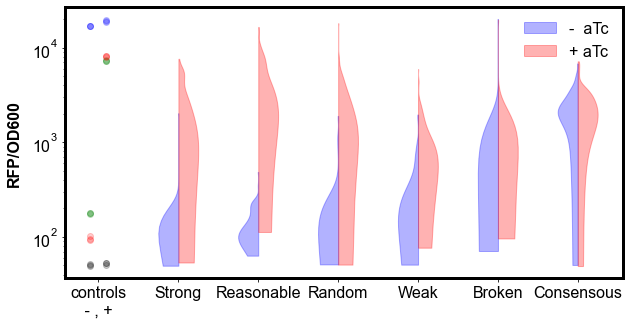

In [311]:
plt.figure(figsize=(10,5))
v1 = plt.violinplot([get_all_data(RFP,l+'_0')/get_all_data(OD,l+'_0') for l in libs], showextrema=False, showmeans = False)

for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
    b.set_color('b')
    
v2 = plt.violinplot([get_all_data(RFP,l+'_200')/get_all_data(OD,l+'_200') for l in libs], showextrema=False, showmeans = False)

for b in v2['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further left than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')

plt.ylabel('RFP/OD600', labelpad = ypad)
plt.xticks([0,1,2,3,4,5,6],['controls\n - , + ',*lib_name])
plt.legend([v1['bodies'][0],v2['bodies'][0]], ['-  aTc', '+ aTc'], frameon = False, loc = 'upper right')
plt.yscale('log')

plt.scatter(3*[-0.1], get_data(exps['off'],RFP,'control_0')/get_data(exps['off'],OD,'control_0'), color = 'k', alpha = 0.2, label = 'off')
plt.scatter(3*[-0.1], get_data(exps['J3'],RFP,'control_0')/get_data(exps['J3'],OD,'control_0'), color = 'g', alpha = 0.2, label = 'J3')
plt.scatter(3*[-0.1], get_data(exps['E'],RFP,'control_0')/get_data(exps['E'],OD,'control_0'), color = 'r', alpha = 0.2, label = 'E')
plt.scatter(3*[-0.1], get_data(exps['119'],RFP,'control_0')/get_data(exps['119'],OD,'control_0'), color = 'b', alpha = 0.2, label = 'max')


plt.scatter(3*[0.1], get_data(exps['off'],RFP,'control_200')/get_data(exps['off'],OD,'control_200'), color = 'k', alpha = 0.2, label = 'off')
plt.scatter(3*[0.1], get_data(exps['J3'],RFP,'control_200')/get_data(exps['J3'],OD,'control_200'), color = 'g', alpha = 0.2, label = 'J3')
plt.scatter(3*[0.1], get_data(exps['E'],RFP,'control_200')/get_data(exps['E'],OD,'control_200'), color = 'r', alpha = 0.2, label = 'E')
plt.scatter(3*[0.1], get_data(exps['119'],RFP,'control_200')/get_data(exps['119'],OD,'control_200'), color = 'b', alpha = 0.2, label = 'max')

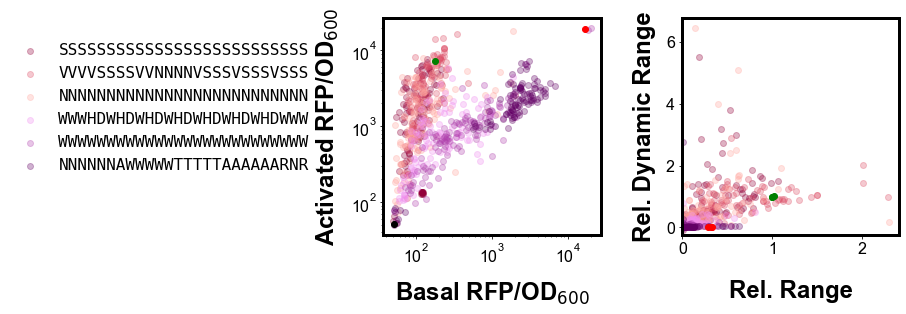

In [312]:
b = 0#np.mean(get_data(exps['off'],RFP,'control_0')/get_data(exps['off'],OD,'control_0'))
colors = ['#93003a', '#dd4c65', '#ffa59e', '#f08cef', '#b041ad', '#630065']

plt.figure(figsize = (10,4))

plt.subplot(121)
for l, lbl,c in zip(libs,lib_name,colors):
    plt.scatter(get_all_data(RFP,l+'_0')/get_all_data(OD,l+'_0')-b,get_all_data(RFP,l+'_200')/get_all_data(OD,l+'_200')-b,label = lbl, alpha = 0.3, color = c)

colors = ['black','green','#dd4c65','red']
alpha = [1,1,0.3,1]
texts = []
for c,cc,a,t in zip(['off','J3','E','119'],colors,alpha,['no RFP','J3','','J23119']):
    l= 'control'
    basal = np.mean(get_data(exps[c], RFP,l+'_0')/get_data(exps[c], OD,l+'_0'))-b
    activated = np.mean(get_data(exps[c],RFP,l+'_200')/get_data(exps[c], OD,l+'_200'))-b
    plt.scatter(basal,activated, color = cc,alpha = a)
#     if c != 'E':
#         texts.append(plt.text(basal, activated, t, ha='center', va='center',size = 12))
        
legend = ['SSSSSSSSSSSSSSSSSSSSSSSSSS',
      'VVVVSSSSVVNNNNVSSSVSSSVSSS',
      'NNNNNNNNNNNNNNNNNNNNNNNNNN',
      'WWWHDWHDWHDWHDWHDWHDWHDWWW',
      'WWWWWWWWWWWWWWWWWWWWWWWWWW',
      'NNNNNNAWWWWWTTTTTAAAAAARNR']
    
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Activated RFP/OD$_{600}$', labelpad = ypad, fontsize = 24)
plt.xlabel('Basal RFP/OD$_{600}$', labelpad = xpad, fontsize = 24)
plt.ylim(plt.gca().get_xlim())
plt.gca().set_aspect(1./plt.gca().get_data_ratio())
plt.xlim(plt.gca().get_xlim())

#lim = 1e5
#plt.plot([0,lim],[0,lim],'k-', alpha = 0.1)
#plt.plot([0,lim],[0,lim*10], 'k-', alpha = 0.1)
#plt.plot([0,lim],[0,lim*100], 'k-', alpha = 0.1)

adjust_text(texts, force_points = (200,20), arrowprops=dict(arrowstyle='-', color='gray', alpha = 0.5))



plt.subplot(122)
b=get_data(exps['off'], RFP,'control_0')/get_data(exps['off'], OD,'control_0')
c = 'J3'
offf = get_data(exps[c], RFP,'control_0')/get_data(exps[c], OD,'control_0')-b.mean()
onn = get_data(exps[c],RFP,'control_200')/get_data(exps[c], OD,'control_200')-b.mean()
cR = onn-offf
cDR = onn/offf

c = '119'
offf = get_data(exps[c], RFP,'control_0')/get_data(exps[c], OD,'control_0')-b.mean()
onn = get_data(exps[c],RFP,'control_200')/get_data(exps[c], OD,'control_200')-b.mean()
mR = onn-offf
mDR = onn/offf

pareto2 = lambda A, B: [~(np.any((A>a) & (B>b))) for a,b in zip(A,B)]
colors = ['#93003a', '#dd4c65', '#ffa59e', '#f08cef', '#b041ad', '#630065']

for l, lbl,c in zip(libs,lib_name,colors):
    basal = get_all_data(RFP,l+'_0')/get_all_data(OD,l+'_0')-np.mean(get_data(exps['off'],RFP,'control_0')/get_data(exps['off'],OD,'control_0'))
    activated = get_all_data(RFP,l+'_200')/get_all_data(OD,l+'_200')-np.mean(get_data(exps['off'],RFP,'control_200')/get_data(exps['off'],OD,'control_200'))
    plt.scatter((activated-basal)/cR.mean(),(activated/basal)/cDR.mean(),label = lbl, alpha = 0.3, color = c)
    
l = plt.legend(legend, frameon=False, bbox_to_anchor=(-1.65, .95), prop = font_manager.FontProperties(family='monospace'))

#plt.scatter(R[pareto2(DR,R)],DR[pareto2(DR,R)], color = 'k', alpha = 1, s = 200,facecolors='none')
plt.scatter(cR/cR.mean(),cDR/cDR.mean(), color = 'g', alpha = 1)
plt.scatter(mR/cR.mean(),mDR/cDR.mean(), color = 'r', alpha = 1)
plt.xlabel('Rel. Range',labelpad = 1.5*xpad, fontsize=24)
plt.ylabel('Rel. Dynamic Range',labelpad = ypad, fontsize =24)
plt.xlim((-50/cR.mean(), 17060.76544007391/cR.mean()))
plt.ylim((-.25, 385.92886691264357/cDR.mean()))

plt.gca().set_aspect(1./plt.gca().get_data_ratio())

# texts = []
# texts.append(plt.text(cR.mean(), cDR.mean(), 'J3', ha='center', va='center',size = 12))
# texts.append(plt.text(mR.mean(), mDR.mean(), 'J23119', ha='center', va='center',size = 12))
# adjust_text(texts, force_points = (20,20), arrowprops=dict(arrowstyle='-', color='gray', alpha = 0.5))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=None)
plt.savefig('figures/Fig2B.svg')

In [313]:
b0 = np.mean(get_data(exps['off'],RFP,'control_0')/get_data(exps['off'],OD,'control_0'))
b200 = np.mean(get_data(exps['off'],RFP,'control_200')/get_data(exps['off'],OD,'control_200'))
J30 = np.mean(get_data(exps['J3'],RFP,'control_0')/get_data(exps['J3'],OD,'control_0'))
J3200 = np.mean(get_data(exps['J3'],RFP,'control_200')/get_data(exps['J3'],OD,'control_200'))

nB = lambda B: (B-b0.mean())/(J30.mean()-b0.mean())
nA = lambda A: (A-b200.mean())/(J3200.mean()-b200.mean())

nN = lambda B: (B-b0.mean())


In [314]:
rel_UP_libs_0 = nB(sum([list(get_all_data(RFP,l+'_0')/get_all_data(OD,l+'_0')) for l in libs[:-1]],[]))
rel_UP_libs_200 = nB(sum([list(get_all_data(RFP,l+'_200')/get_all_data(OD,l+'_200')) for l in libs[:-1]],[]))

In [315]:
FA = [nN((get_all_data(RFP,l+'_200')/get_all_data(OD,l+'_200')))/nN((get_all_data(RFP,l+'_0')/get_all_data(OD,l+'_0'))) for l in libs]
ac = [nN((get_all_data(RFP,l+'_200')/get_all_data(OD,l+'_200'))) for l in libs]
bc = [nN((get_all_data(RFP,l+'_0')/get_all_data(OD,l+'_0'))) for l in libs]

In [362]:
np.mean(FA,1)

array([43.836004  , 42.64661563, 37.62689186,  7.34151244,  2.71559233,
        2.84352199])

C:\Users\Diego Alba\.conda\envs\txtl-sim\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
C:\Users\Diego Alba\.conda\envs\txtl-sim\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


2083.0 +/- 1909.3780836452083
3818.0 +/- 3307.5502726228938
2109.0 +/- 2295.845716230523
951.0 +/- 968.1120890319402
1224.0 +/- 2569.0976396019055
2263.0 +/- 1416.8938174240393


C:\Users\Diego Alba\.conda\envs\txtl-sim\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Diego Alba\.conda\envs\txtl-sim\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


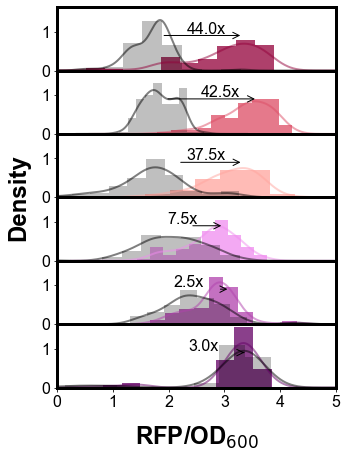

In [368]:
f,ax = plt.subplots(6, 1,figsize=(5,7), sharey = True, sharex = True, squeeze=True)
for f,g,c,x in zip(ac,bc,colors,ax):
    x.hist(np.log10(f), alpha = 0.75, color = c, bins = 10, density = True)
    pd.Series(np.log10(f)).plot(kind = 'kde', color = c, alpha = 0.5, ax = x)
    
    x.hist(np.log10(g), alpha = 0.25, color = 'k', bins = 10, density = True)
    pd.Series(np.log10(g)).plot(kind = 'kde', color = 'k', alpha = 0.5, ax = x)
    
    x.set_xlim([0,4.8])
    x.set_xticks([0,1,2,3,4,5])
    
    avg = np.round(np.mean(f),0)
    err = np.std(f)
    print(str(avg)+' +/- '+str(err))
    x.set_ylabel('')
    
    x.annotate("", xy=(np.log10(g.mean()), 0.9), xytext=(np.log10(f.mean()), 0.9),
             arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color = 'k', lw = 1))

    x.text(np.log10(f.mean())-1,0.95, '{x:.{d}f}x'.format(x=np.round(2*np.mean(f/g))/2,d=1))

plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel('RFP/OD$_{600}$', labelpad = xpad, fontsize = 24)
plt.ylabel('Density', y = 3, labelpad=ypad*1.1, fontsize = 24)

plt.savefig('UP-densities.svg')

In [332]:
(J3200-b200)-(J30-b0)

7075.28447479398

In [330]:
np.max(FA)/((J3200-b200)/(J30-b0))

6.48450137919221

In [333]:
np.max([nN((get_all_data(RFP,l+'_200')/get_all_data(OD,l+'_200')))-nN((get_all_data(RFP,l+'_0')/get_all_data(OD,l+'_0'))) for l in libs])/((J3200-b200)-(J30-b0))

2.29427040125304

In [199]:
optUP = [pareto(a,b) for a,b in zip(ac,bc)]

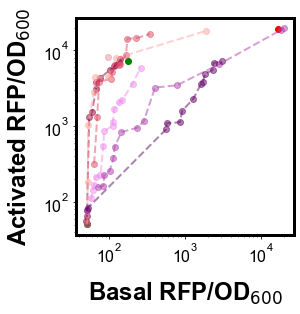

In [369]:
b = 0#np.mean(get_data(exps['off'],RFP,'control_0')/get_data(exps['off'],OD,'control_0'))
colors = ['#93003a', '#dd4c65', '#ffa59e', '#f08cef', '#b041ad', '#630065']

plt.figure(figsize = (10,4))

plt.subplot(121)
for l, lbl,c,k in zip(libs,lib_name,colors,range(6)):
    sort_id = np.argsort(get_all_data(RFP,l+'_0')[optUP[k]]/get_all_data(OD,l+'_0')[optUP[k]]-b)
    
    plt.plot((get_all_data(RFP,l+'_0')[optUP[k]]/get_all_data(OD,l+'_0')[optUP[k]]-b)[sort_id],(get_all_data(RFP,l+'_200')[optUP[k]]/get_all_data(OD,l+'_200')[optUP[k]]-b)[sort_id],label = lbl, alpha = 0.5, color = c, marker = 'o', linestyle='--')

colors = ['black','green','#dd4c65','red']
alpha = [1,1,0.3,1]
texts = []
for c,cc,a,t in zip(['off','J3','E','119'],colors,alpha,['no RFP','J3','','J23119']):
    l= 'control'
    basal = np.mean(get_data(exps[c], RFP,l+'_0')/get_data(exps[c], OD,l+'_0'))-b
    activated = np.mean(get_data(exps[c],RFP,l+'_200')/get_data(exps[c], OD,l+'_200'))-b
    plt.scatter(basal,activated, color = cc,alpha = a)
#     if c != 'E':
#         texts.append(plt.text(basal, activated, t, ha='center', va='center',size = 12))
        
legend = ['SSSSSSSSSSSSSSSSSSSSSSSSSS',
      'VVVVSSSSVVNNNNVSSSVSSSVSSS',
      'NNNNNNNNNNNNNNNNNNNNNNNNNN',
      'WWWHDWHDWHDWHDWHDWHDWHDWWW',
      'WWWWWWWWWWWWWWWWWWWWWWWWWW',
      'NNNNNNAWWWWWTTTTTAAAAAARNR']
    
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Activated RFP/OD$_{600}$', labelpad = ypad, fontsize = 24)
plt.xlabel('Basal RFP/OD$_{600}$', labelpad = xpad, fontsize = 24)
plt.ylim(plt.gca().get_xlim())
plt.gca().set_aspect(1./plt.gca().get_data_ratio())
plt.xlim(plt.gca().get_xlim())

plt.savefig('UP-paretos.svg')

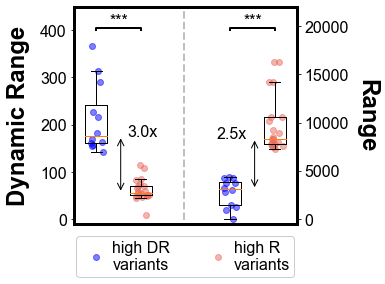

In [422]:
g_nDRs,b_nRs = [],[]
b_nDRs,g_nRs = [],[]

fig, ax1 = plt.subplots(figsize = (4,4))
ax2 = ax1.twinx()

for l, lbl,c in zip(libs,lib_name,colors):
    basal = get_all_data(RFP,l+'_0')/get_all_data(OD,l+'_0')-np.mean(get_data(exps['off'],RFP,'control_0')/get_data(exps['off'],OD,'control_0'))
    activated = get_all_data(RFP,l+'_200')/get_all_data(OD,l+'_200')-np.mean(get_data(exps['off'],RFP,'control_200')/get_data(exps['off'],OD,'control_200'))
    
    nDR = (activated/basal)#/cDR.mean()
    nR = (activated-basal)#/cR.mean()
        
    median = 2.5*cDR.mean()
    ax1.scatter(np.random.rand(sum(nDR>median))/3,nDR[nDR>median],alpha = 0.5, color = 'b')
    ax2.scatter(np.random.rand(sum(nDR>median))/3+3,nR[nDR>median],alpha = 0.5, color = 'b')
    
    g_nDRs.append(list(nDR[nDR>median]))
    b_nRs.append(list(nR[nDR>median]))
    
    median = 1*cR.mean()
    ax1.scatter(np.random.rand(sum(nR>median))/3+1,nDR[nR>median], alpha = 0.5, color = '#e86a5e')
    ax2.scatter(np.random.rand(sum(nR>median))/3+4,nR[nR>median], alpha = 0.5, color = '#e86a5e')
    
    b_nDRs.append(list(nDR[nR>median]))
    g_nRs.append(list(nR[nR>median]))

Y = [sum(l,[]) for l in [g_nDRs, b_nDRs, b_nRs, g_nRs]]
bp = ax1.boxplot(np.array(Y[:-2],dtype=object).T,positions = [0.15,1.15], showfliers=False, widths = 0.5)
bp = ax2.boxplot(np.array(Y[-2:],dtype=object).T,positions = [3.15,4.15], showfliers=False, widths = 0.5)

ax1.plot([4.25/2, 4.25/2],[-1,500],'k--', alpha = 0.25)
ax1.set_ylim([-10,450])
ax2.set_ylim([-500,22000])

ax1.set_ylabel('Dynamic Range', labelpad = ypad, fontsize = 24)
ax2.set_ylabel('Range', labelpad = 3*ypad, fontsize = 24, rotation = 270)

ax1.plot([1],[-200],'ob', label = 'high DR\nvariants', alpha = 0.5)
ax1.plot([1],[-200],'o', label = 'high R\nvariants', alpha = 0.5, color = '#e86a5e')

ax1.legend(loc='center', handletextpad = 0, borderpad=0.25, framealpha = 1, ncol =2, bbox_to_anchor=(0.5, -0.15))
ax1.set_xticks([])

xlocs = [0.15,1.15, 3.15,4.15]
ylocs = [16200]*4
put_pval(0, 1, stats.median_test(Y[0],Y[1])[1], xlocs, ylocs, dh = 0.15, barh = .01, maxasterix = 3)
put_pval(2, 3, stats.median_test(Y[2],Y[3])[1], xlocs, ylocs, dh = 0.15, barh = .01, maxasterix = 3)

medians = [np.median(y) for y in Y]
del_m1 = medians[0]/medians[1]
del_m2 = medians[3]/medians[2]

ax1.annotate("", xy=(0.7, medians[0]), xytext=(0.7, medians[1]),
             arrowprops=dict(arrowstyle="<->", connectionstyle="arc3", color = 'k', lw = 1))

ax1.text(0.85,medians[0], '{x:.{d}f}x'.format(x=np.round(2*del_m1)/2,d=1))

ax2.annotate("", xy=(3.7, medians[3]), xytext=(3.7, medians[2]),
             arrowprops=dict(arrowstyle="<->", connectionstyle="arc3", color = 'k', lw = 1))

ax2.text(2.85,medians[3], '{x:.{d}f}x'.format(x=np.round(2*del_m2)/2,d=1))

plt.savefig('figures/Fig2B_right.svg')

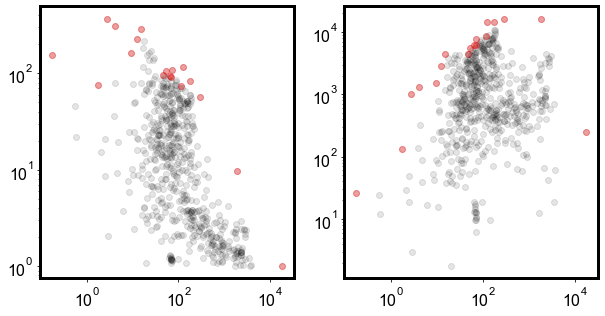

In [108]:
plt.figure(figsize = (10,5))
plt.subplot(121)
B = np.array([])
A = np.array([])
for l, lbl in zip(libs,lib_name):
    B = np.append(B,get_all_data(RFP,l+'_0')/get_all_data(OD,l+'_0')-np.mean(get_data(exps['off'],RFP,'control_0')/get_data(exps['off'],OD,'control_0')))
    A = np.append(A,get_all_data(RFP,l+'_200')/get_all_data(OD,l+'_200')-np.mean(get_data(exps['off'],RFP,'control_200')/get_data(exps['off'],OD,'control_200')))

nonneg = np.logical_and(np.logical_and((A>0), (A>B)),(B>0))
A = A[nonneg]
B = B[nonneg]

DR = A/B
R = A-B
plt.subplot(121)
plt.scatter(B, DR, label = lbl, alpha = 0.1, color = 'k')
plt.scatter(B[pareto(A,B)], DR[pareto(A,B)], label = lbl, alpha = 0.3, color = 'r')
#plt.scatter(B[pareto(DR,B)], DR[pareto(DR,B)], label = lbl, alpha = 0.3, color = 'r')

plt.xscale('log')
plt.yscale('log')

plt.subplot(122)
plt.scatter(B, R, label = lbl, alpha = 0.1, color = 'k')
plt.scatter(B[pareto(A,B)], R[pareto(A,B)], label = lbl, alpha = 0.3, color = 'r')
#plt.scatter(B[pareto(R,B)], R[pareto(R,B)], label = lbl, alpha = 0.3, color = 'g')

plt.xscale('log')
plt.yscale('log')


Check if growth defect actually had an impact.

In [49]:
ods_0 = [get_all_data(OD,l+'_0') for l in libs]
rfps_0 = [get_all_data(RFP,l+'_0') for l in libs]

ods_200 = [get_all_data(OD,l+'_200') for l in libs]
rfps_200 = [get_all_data(RFP,l+'_200') for l in libs]

In [76]:
def twoSampZ(X1, X2, mudiff, sd1, sd2, n1, n2, alpha):
    from numpy import sqrt, abs, round
    pooledSE = sqrt(sd1**2/n1 + sd2**2/n2)
    z = ((X1 - X2) - mudiff)/pooledSE
    pval = 2*(1 - stats.norm.cdf(abs(z))) #two-tailed
    return round(z, 3), round(pval, 4), pval > alpha, n1, n2 # p > a, keep null

def twoSampT(X,Y,var,alpha):
    t,pval = stats.ttest_ind(X,Y, equal_var = var)
    return round(t, 3), round(pval, 4), pval > alpha

alpha = 0.05

In [323]:
od_thresh = lambda od: 0.85 #np.mean(od)
good = lambda od,rfp: [r[o >= od_thresh(od)]/o[o >= od_thresh(od)] for o,r in zip(od, rfp)]
bad = lambda od,rfp: [r[o < od_thresh(od)]/o[o < od_thresh(od)] for o,r in zip(od, rfp)]

(-0.5, 6.5)

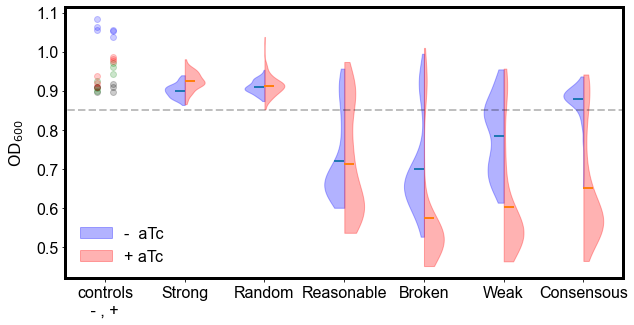

In [333]:
plt.figure(figsize=(10,5))
v1 = plt.violinplot([get_all_data(OD,l+'_0') for l in libs], showextrema=False, showmeans = True)
for k in range(0,len(libs)): v1['cmeans'].get_paths()[k].vertices[1,0] = k+1
v1['cmeans'].set_linewidth(2)

for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
    b.set_color('b')
    
v2 = plt.violinplot([get_all_data(OD,l+'_200') for l in libs], showextrema=False, showmeans = True)
#plt.yscale('log')
for k in range(0,len(libs)): v2['cmeans'].get_paths()[k].vertices[0,0] = k+1
v2['cmeans'].set_linewidth(2)


for b in v2['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further left than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('r')

plt.ylabel('$\mathrm{OD_{600}}$', labelpad = ypad)
plt.xticks([0,1,2,3,4,5,6],['controls\n - , + ',*lib_name])
plt.legend([v1['bodies'][0],v2['bodies'][0]], ['-  aTc', '+ aTc'], frameon = False, loc = 'lower left')

plt.scatter(3*[-0.1], get_data(exps['off'],OD,'control_0'), color = 'k', alpha = 0.2, label = 'off')
plt.scatter(3*[-0.1], get_data(exps['J3'],OD,'control_0'), color = 'g', alpha = 0.2, label = 'J3')
plt.scatter(3*[-0.1], get_data(exps['E'],OD,'control_0'), color = 'r', alpha = 0.2, label = 'E')
plt.scatter(3*[-0.1], get_data(exps['119'],OD,'control_0'), color = 'b', alpha = 0.2, label = 'max')


plt.scatter(3*[0.1], get_data(exps['off'],OD,'control_200'), color = 'k', alpha = 0.2, label = 'off')
plt.scatter(3*[0.1], get_data(exps['J3'],OD,'control_200'), color = 'g', alpha = 0.2, label = 'J3')
plt.scatter(3*[0.1], get_data(exps['E'],OD,'control_200'), color = 'r', alpha = 0.2, label = 'E')
plt.scatter(3*[0.1], get_data(exps['119'],OD,'control_200'), color = 'b', alpha = 0.2, label = 'max')

plt.plot([-1,8],[0.85,0.85],'k--',alpha = 0.25)
plt.xlim([-0.5,6.5])

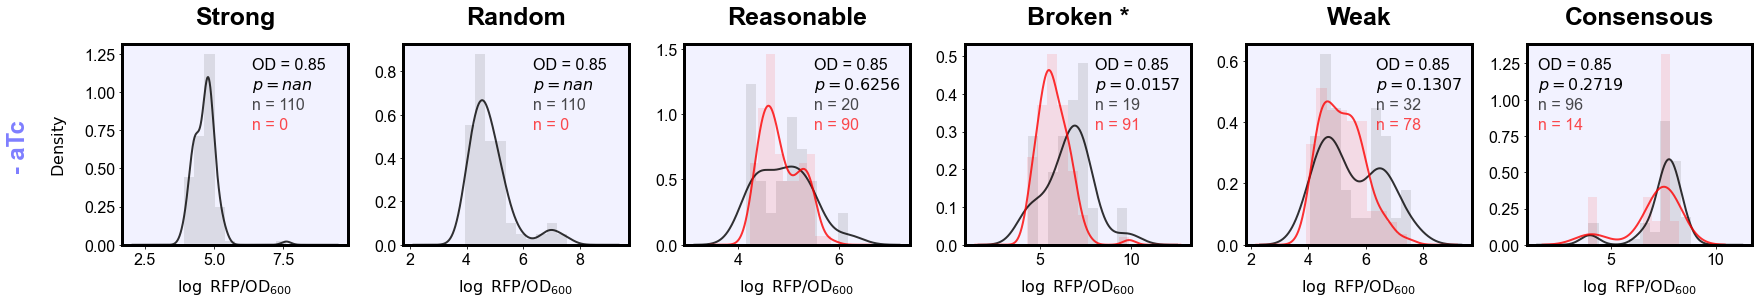

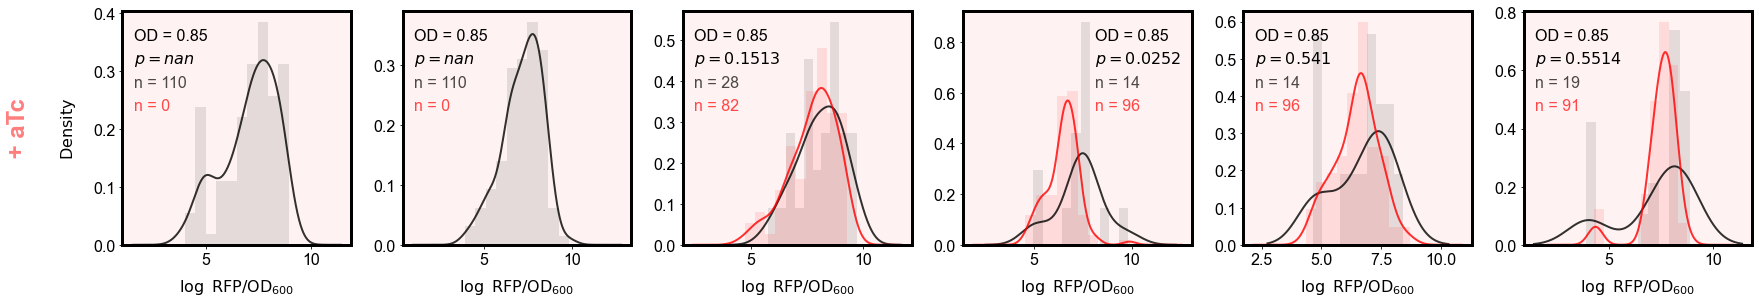

In [347]:
plt.figure(figsize = (24,4.5))
locx = [0.575,0.575,0.575,0.575,0.575,0.05]
for k,(g,b) in enumerate(zip(good(ods_0,rfps_0), bad(ods_0,rfps_0))):
    plt.subplot(1,6,k+1)
    if len(g) > 0: pd.Series(np.log(g)).plot(kind = 'kde', color = 'k', alpha = 0.8)
    if len(b) > 0: pd.Series(np.log(b)).plot(kind = 'kde', color = 'r', alpha = 0.8)
    if len(g) > 0: pd.Series(np.log(g)).plot(kind = 'hist', color = 'k', alpha = 0.1, **{'density':True})
    if len(b) > 0: pd.Series(np.log(b)).plot(kind = 'hist', color = 'r', alpha = 0.1, **{'density':True})
    plt.xlabel('$\mathrm{log\/\/\/RFP/OD_{600}}$', labelpad = 10)
    if k == 0: plt.ylabel('$\mathrm{Density}$', labelpad = 15)
    if k > 0: plt.ylabel('')
    plt.text(locx[k],0.675,'n = {}'.format(len(g)), color = 'k', alpha = 0.7, transform=plt.gca().transAxes)
    plt.text(locx[k],0.575,'n = {}'.format(len(b)), color = 'r', alpha = 0.7, transform=plt.gca().transAxes)
    plt.text(locx[k],0.875,'OD = {}'.format(np.round(od_thresh(ods_0[k]),3)), transform=plt.gca().transAxes)
    pval = twoSampT(np.log(g),np.log(b),False,alpha)[1]
    plt.text(locx[k],0.775,'$p = {}$'.format(pval), transform=plt.gca().transAxes)
    plt.title(lib_name[k], pad = 20)
    if pval < alpha: plt.title(lib_name[k]+' *', pad = 20)

    plt.gca().patch.set_facecolor('b')
    plt.gca().patch.set_alpha(0.05)

plt.figtext(-0.02,0.425,' - aTc',rotation = 90, size = 24, color = 'b', alpha = 0.5, weight = 'bold')
plt.tight_layout()

plt.figure(figsize = (24,4.5))
locx = [0.05,0.05,0.05,0.575,0.05,0.05]
for k,(g,b) in enumerate(zip(good(ods_200,rfps_200), bad(ods_200,rfps_200))):
    plt.subplot(1,6,k+1)
    if len(g) > 0: pd.Series(np.log(g)).plot(kind = 'kde', color = 'k', alpha = 0.8)
    if len(b) > 0: pd.Series(np.log(b)).plot(kind = 'kde', color = 'r', alpha = 0.8)
    if len(g) > 0: pd.Series(np.log(g)).plot(kind = 'hist', color = 'k', alpha = 0.1, **{'density':True})
    if len(b) > 0: pd.Series(np.log(b)).plot(kind = 'hist', color = 'r', alpha = 0.1, **{'density':True})
        
    plt.xlabel('$\mathrm{log\/\/\/RFP/OD_{600}}$', labelpad = 10)
    if k == 0: plt.ylabel('$\mathrm{Density}$', labelpad = 15)
    if k > 0: plt.ylabel('')
    plt.text(locx[k],0.675,'n = {}'.format(len(g)), color = 'k', alpha = 0.7, transform=plt.gca().transAxes)
    plt.text(locx[k],0.575,'n = {}'.format(len(b)), color = 'r', alpha = 0.7, transform=plt.gca().transAxes)
    plt.text(locx[k],0.875,'OD = {}'.format(np.round(od_thresh(ods_200[k]),3)), transform=plt.gca().transAxes)
    pval = twoSampT(np.log(g),np.log(b),False,alpha)[1]
    plt.text(locx[k],0.775,'$p = {}$'.format(pval), transform=plt.gca().transAxes)
    
    plt.gca().patch.set_facecolor('red')
    plt.gca().patch.set_alpha(0.05)
    
plt.figtext(-0.02,0.475,' + aTc',rotation = 90, size = 24, color = 'r', alpha = 0.5, weight = 'bold')

plt.tight_layout()

Results from the quick analysis of N26 libraries data based on a OD600 threshold (here 0.85).

Question: Does "poor" growth (low OD600s) result in statistically different expression distributions (RFP/OD) ?

Approach: two-tailed t-test, null hypothesis being that the mean RFP/OD of the two subsets are the same; alpha = 0.05

Results: p-value only < 0.05 in "Broken" library (both -/+ aTc)  (i.e., even after correcting for OD, these cells have lower expression for some other reason (note x axis is log, so means are quite different)

Takeaway: probably gonna leave the experiment as is, include this analysis and say "be wary of Broken" (or include it only in supplement)

# spacers

In [53]:
Spath = 'activatable promoters/ecoli/spacer/'
(_,_,filenames) = list(walk(Spath))[0]

In [54]:
read_OD = lambda f: pd.read_csv(Spath+f, delimiter  = '\t', skiprows = 52, index_col = (13,0)).loc['600'].set_index('Unnamed: 0')
OD = {f[:-4] : read_OD(f) for f in filenames if f[-3:] == 'txt'}

read_RFP= lambda f: pd.read_csv(Spath+f, delimiter  = '\t', skiprows = 52, index_col = (13,0)).loc['GFP+RFP:540/35,600/40'].set_index('Unnamed: 0').set_index(OD[f[:-4]].index)
RFP = {f[:-4] : read_RFP(f) for f in filenames if f[-3:] == 'txt'}

In [55]:
plate = pd.read_csv(Spath+'210817-C_LAYOUT.csv', index_col = 0, dtype = str) # reads plate layout

# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append((i[0], i[1]))
            
lib = [(r,c) for r in RFP['Plate_S'].index for c in RFP['Plate_S'].columns]
libs = ['Plate_W','Plate_X','Plate_S', 'Plate_C']
lib_name = ['A/T only','random','G/C only']

get_data = lambda X, df, lbl: np.array([df[lbl].loc[x] for x in X])
get_data_df = lambda X, df, lbl: ([df[lbl].loc[x] for x in X])

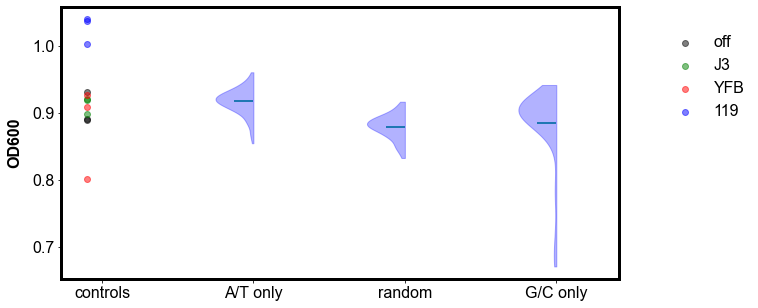

In [56]:
plt.figure(figsize=(10,5))
v1 = plt.violinplot([get_data(lib,OD,l) for l in libs[:-1]], showextrema=False, showmeans = True)
for k in range(0,len(libs[:-1])): v1['cmeans'].get_paths()[k].vertices[1,0] = k+1
v1['cmeans'].set_linewidth(2)

for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
    b.set_color('b')
    

plt.ylabel('OD600', labelpad = ypad)
plt.xticks([0,1,2,3],['controls',*lib_name])

plt.scatter(3*[-0.1], get_data(exps['J2'],OD,'Plate_C'), color = 'k', alpha = 0.5, label = 'off')
plt.scatter(3*[-0.1], get_data(exps['J306'],OD,'Plate_C'), color = 'g', alpha = 0.5, label = 'J3')
plt.scatter(3*[-0.1], get_data(exps['YFB'],OD,'Plate_C'), color = 'r', alpha = 0.5, label = 'YFB')
plt.scatter(3*[-0.1], get_data(exps['119'],OD,'Plate_C'), color = 'b', alpha = 0.5, label = '119')

plt.legend(frameon = False, bbox_to_anchor=(1.25, .95))

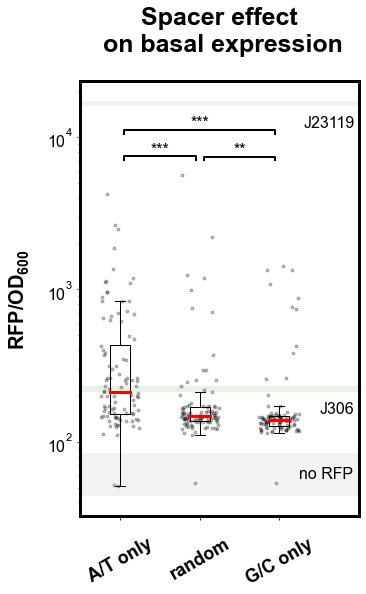

In [57]:

Y = [get_data(lib,RFP,l)/get_data(lib,OD,l) for l in libs[:-1]]
YFB = [get_data(exps['YFB'],RFP,l)/get_data(exps['YFB'],OD,l) for l in [libs[-1]]]

Y[1] = np.append(Y[1],YFB)
X = [(np.random.rand(len(y))-0.5)/2 for y in Y]

plt.figure(figsize = (5,8))
[plt.scatter(x+z,y, alpha = 0.25,marker='.', color = 'k') for x,y,z in zip(X,Y,[1,2,3])]
bp = plt.boxplot(np.array(Y,dtype=object).T,showfliers=False, widths = 0.25)

for median in bp['medians']: 
    median.set(color ='red', 
               linewidth = 3) 
    
top = [get_data(exps['119'],RFP,l)/get_data(exps['119'],OD,l) for l in [libs[-1]]]
plt.axhspan(np.mean(top)-np.std(top), np.mean(top)+np.std(top), facecolor='0.5',alpha = 0.1)
plt.text(3.3, np.mean(top)*0.7,'J23119', rotation = 0)

bot = [get_data(exps['J2'],RFP,l)/get_data(exps['J2'],OD,l) for l in [libs[-1]]]
plt.axhspan(np.mean(bot)-np.std(bot), np.mean(bot)+np.std(bot), facecolor='0.5', alpha = 0.1)
plt.text(3.25, np.mean(bot)*0.9,'no RFP', rotation = 0)

J306 = [get_data(exps['J306'],RFP,l)/get_data(exps['J306'],OD,l) for l in [libs[-1]]]
plt.axhspan(np.mean(J306)-np.std(J306), np.mean(J306)+np.std(J306), facecolor='green',alpha = 0.1)
plt.text(3.5, np.mean(J306)*0.7,'J306', rotation = 0)

plt.xticks([1,2,3],labels = lib_name, size = 18, weight = 'bold', rotation = 30)
plt.gca().xaxis.set_tick_params(pad=xpad)


xlocs = [1.05,1.95,2.05,2.95]
ylocs = [val for val in [np.max(y) for y in Y] for _ in (0, 1)]
put_pval(0, 1, stats.median_test(Y[0],Y[1])[1], xlocs, ylocs, dh = 0.15, barh = .02, maxasterix = 3)
put_pval(2, 3, stats.median_test(Y[1],Y[2])[1], xlocs, ylocs, dh = 0.075, barh = .02)
put_pval(0, 3, stats.median_test(Y[0],Y[2])[1], xlocs, ylocs, dh = 0.25, barh = .04, maxasterix =3)

plt.xlim([0.5,4])
plt.yscale('log')
plt.ylabel('$\mathregular{RFP/OD_{600}}$', labelpad = 1.5*ypad, size = 20, weight = 'bold')
plt.title('Spacer effect\n on basal expression', pad = 2*xpad)
ylim_spacers = plt.gca().get_ylim()

In [60]:
nY = [(y-np.mean(bot))/(np.mean(J306)-np.mean(bot)) for y in Y]

In [79]:
rel_spacers_libs_0 = sum(map(list,nY),[])

In [97]:
picked = [('F','8'),('H','5'),('A','9'),('G','8'),('E','2'),('F','10'),('A','12'),('G','5'),('C','9'),('F','11')]

In [98]:
og_basal = [get_data(picked,RFP,l)/get_data(picked,OD,l) for l in [libs[1]]]
og_basal = (og_basal-np.mean(bot))/(np.mean(J306)-np.mean(bot))
og_basal

array([[0.36371859, 0.36048372, 0.46313061, 0.37319057, 0.39073934,
        0.44938617, 0.4431714 , 0.42869821, 0.39817333, 0.52467202]])

spacers E

In [99]:
Spath = 'activatable promoters/ecoli/spacer_E/'
(_,_,filenames) = list(walk(Spath))[0]

read_OD = lambda f: pd.read_csv(Spath+f, delimiter  = '\t', skiprows = 52, index_col = (13,0)).loc['600'].set_index('Unnamed: 0')
OD_E = {f[:-4] : read_OD(f) for f in filenames if f[-3:] == 'txt'}

read_RFP= lambda f: pd.read_csv(Spath+f, delimiter  = '\t', skiprows = 52, index_col = (13,0)).loc['GFP+RFP:540/35,600/40'].set_index('Unnamed: 0').set_index(OD_E[f[:-4]].index)
RFP_E = {f[:-4] : read_RFP(f) for f in filenames if f[-3:] == 'txt'}

#plate = pd.read_csv(Spath+'210902-control_LAYOUT.csv', index_col = 0, dtype = str) # reads plate layout

# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
# labels = pd.unique(np.concatenate(plate.values))
# exps = {}
# xlbl = []
# for l in labels:
#     if type(l) is str:
#         xlbl.append(l)
#         index = plate[plate.isin([l])].stack().index
#         exps[l] = []
#         for i in index:
#             exps[l].append((i[0], i[1]))
            
lib = [(r,c) for r in RFP_E['Plate_S'].index for c in RFP_E['Plate_S'].columns]
controls = lib[:3]
lib = lib [3:]
libs = ['Plate_W','Plate_X','Plate_S', 'control']
lib_name = ['A/T only','random','G/C only']

get_data = lambda X, df, lbl: np.array([df[lbl].loc[x] for x in X])

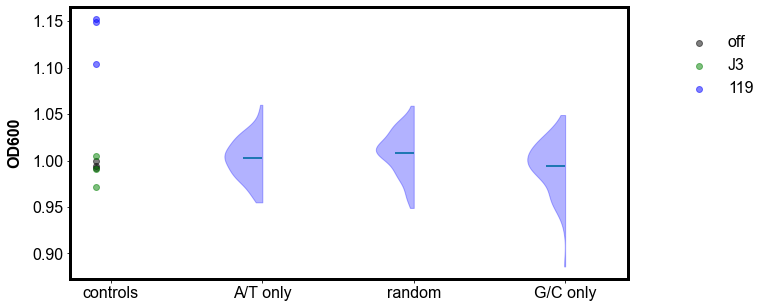

In [100]:
plt.figure(figsize=(10,5))
v1 = plt.violinplot([get_data(lib,OD_E,l) for l in libs[:-1]], showextrema=False, showmeans = True)
for k in range(0,len(libs[:-1])): v1['cmeans'].get_paths()[k].vertices[1,0] = k+1
v1['cmeans'].set_linewidth(2)

for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
    b.set_color('b')
    

plt.ylabel('OD600', labelpad = ypad)
plt.xticks([0,1,2,3],['controls',*lib_name])

plt.scatter(3*[-0.1], get_data(controls,OD_E,'Plate_W'), color = 'k', alpha = 0.5, label = 'off')
plt.scatter(3*[-0.1], get_data(controls,OD_E,'Plate_X'), color = 'g', alpha = 0.5, label = 'J3')
plt.scatter(3*[-0.1], get_data(controls,OD_E,'Plate_S'), color = 'b', alpha = 0.5, label = '119')

plt.legend(frameon = False, bbox_to_anchor=(1.25, .95))

Text(0.5, 1.0, 'Spacer effect\n on basal expression\n (low leak UP)')

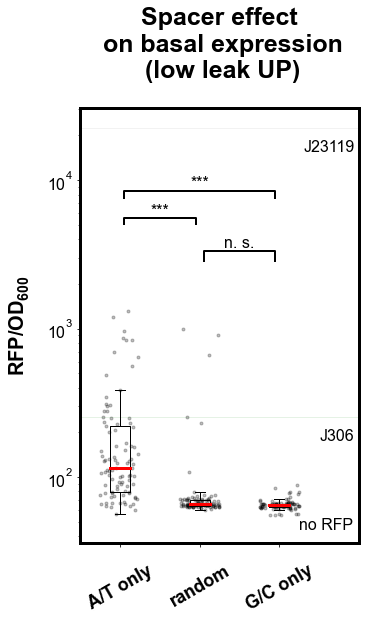

In [101]:

Y = [get_data(lib,RFP_E,l)/get_data(lib,OD_E,l) for l in libs[:-1]]
X = [(np.random.rand(len(y))-0.5)/2 for y in Y]

plt.figure(figsize = (5,8))
[plt.scatter(x+z,y, alpha = 0.25,marker='.', color = 'k') for x,y,z in zip(X,Y,[1,2,3])]
bp = plt.boxplot(np.array(Y,dtype=object).T,showfliers=False, widths = 0.25)

for median in bp['medians']: 
    median.set(color ='red', 
               linewidth = 3) 
    
top = [get_data(controls,RFP_E,l)/get_data(controls,OD_E,l) for l in ['Plate_S']]
plt.axhspan(np.mean(top)-np.std(top)*2, np.mean(top)+np.std(top)*2, facecolor='0.5',alpha = 0.1)
plt.text(3.3, np.mean(top)*0.7,'J23119', rotation = 0)

bot = [get_data(controls,RFP_E,l)/get_data(controls,OD_E,l) for l in ['Plate_W']]
plt.axhspan(np.mean(bot)-np.std(bot), np.mean(bot)+np.std(bot), facecolor='0.5', alpha = 0.1)
plt.text(3.25, np.mean(bot)*0.9,'no RFP', rotation = 0)

J306 = [get_data(controls,RFP_E,l)/get_data(controls,OD_E,l) for l in ['Plate_X']]
plt.axhspan(np.mean(J306)-np.std(J306), np.mean(J306)+np.std(J306), facecolor='green',alpha = 0.1)
plt.text(3.5, np.mean(J306)*0.7,'J306', rotation = 0)

plt.xticks([1,2,3],labels = lib_name, size = 18, weight = 'bold', rotation = 30)
plt.gca().xaxis.set_tick_params(pad=xpad)


xlocs = [1.05,1.95,2.05,2.95]
ylocs = [val for val in [np.max(y) for y in Y] for _ in (0, 1)]
put_pval(0, 1, stats.median_test(Y[0],Y[1])[1], xlocs, ylocs, dh = 0.15, barh = .02, maxasterix = 3)
put_pval(2, 3, stats.median_test(Y[1],Y[2])[1], xlocs, ylocs, dh = 0.075, barh = .02)
put_pval(0, 3, stats.median_test(Y[0],Y[2])[1], xlocs, ylocs, dh = 0.25, barh = .04, maxasterix =3)

plt.xlim([0.5,4])
#plt.ylim(ylim_spacers)
plt.yscale('log')
plt.ylabel('$\mathregular{RFP/OD_{600}}$', labelpad = 1.5*ypad, size = 20, weight = 'bold')
plt.title('Spacer effect\n on basal expression\n (low leak UP)', pad = 2*xpad)

In [102]:
nY_E = [(y-np.mean(bot))/(np.mean(J306)-np.mean(bot)) for y in Y]

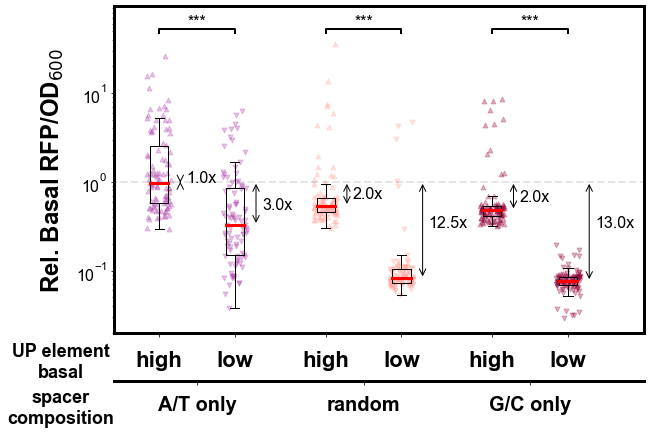

In [113]:
Y = [nY[0],nY_E[0],nY[1],nY_E[1],nY[2],nY_E[2]]
Y = [y[y>0] for y in Y]
X = [(np.random.rand(len(y))-0.5)/2.5 for y in Y]

colors = ['#b041ad', '#b041ad','#ffa59e','#ffa59e','#93003a','#93003a']
alphas = [0.3]*6
markers = ['^','v']*3

xlocs = [0,1.25,2.75,4,5.5,6.75]
plt.figure(figsize = (9.5,6))
[plt.scatter(x+z,y,marker=m, color = c,alpha =a, s = 24) for x,y,z,c,a,m in zip(X,Y,xlocs,colors,alphas,markers)]
bp = plt.boxplot(np.array(Y,dtype=object).T,positions = xlocs, showfliers=False, widths = 0.3)
ax = plt.gca()

medians = []
for median,c in zip(bp['medians'],colors): 
    median.set(color ='r', linewidth = 3)
    y = median.get_ydata()[0]
    x = median.get_xdata()[1]
    medians.append(median.get_ydata()[0])
    
    ax.annotate("", xy=(x+0.2, 1), xytext=(x+0.2, y),
                 arrowprops=dict(arrowstyle="<->", connectionstyle="arc3", color = 'k', lw = 1))
    ax.text(x+0.3,y+(1-y)/4, '{x:.{d}f}x'.format(x=np.round(2/y)/2,d=1))

ax.set_xlim([-.75,8])
plt.plot([-1,8],[1,1],'k--', alpha =0.1)
plt.ylim([0.02,95])  
plt.yscale('log')

ylocs = [19]*6
put_pval(0, 1, stats.median_test(Y[0],Y[1])[1], xlocs, ylocs, dh = 0.3, barh = .05, maxasterix = 3)
put_pval(2, 3, stats.median_test(Y[2],Y[3])[1], xlocs, ylocs, dh = 0.3, barh = .05, maxasterix =3)
put_pval(4, 5, stats.median_test(Y[4],Y[5])[1], xlocs, ylocs, dh = 0.3, barh = .05, maxasterix =3)

# Second X-axis
ax2 = ax.twiny(); ax2.set_xlim(ax.get_xlim())
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.spines["bottom"].set_position(("axes", -0.15))

ax.tick_params(axis='x', which='major', pad=14)
ax.set_xlabel('UP element\nbasal', size = 18)
ax.xaxis.set_label_coords(-0.10, -0.03)
ax.set_xticklabels(labels = ['high','low']*3, size = 22, weight = 'bold')

ax2.tick_params(axis='x', which='major', pad=10)
ax2.set_xlabel('spacer\ncomposition', size = 18)
ax2.xaxis.set_label_coords(-0.10, -0.17)
ax2.set_xticks([(x2-x1)/2+x1 for x1,x2 in zip(xlocs[::2],xlocs[1::2])])
ax2.set_xticklabels(labels = lib_name, size = 20, weight = 'bold')

ax.set_ylabel('Rel. Basal RFP/OD$_{600}$', labelpad = ypad, size = 24, weight = 'bold')
plt.savefig('figures/Fig2C.svg')

In [234]:
from scipy.stats import bootstrap, gaussian_kde, kurtosis, norm

def kurt(x,axis):
    return np.array(kurtosis(x))

alpha = 0.05
n=9999
Z = norm.ppf(1-alpha/2)

CI = bootstrap((Y[0],),kurt,confidence_level=1-alpha, n_resamples = n).confidence_interval
(CI.high-CI.low)/2/Z*np.sqrt(n)

62.978093817387006

In [235]:
CI

ConfidenceInterval(low=15.587057144421868, high=18.05587650241721)

In [309]:
path = 'activatable promoters/ecoli/spacer_sele/'
(_,_,filenames) = list(walk(path))[0]

read_OD = lambda f: pd.read_csv(path+f, delimiter  = '\t', skiprows = 52, index_col = (13,0)).loc['600'].set_index('Unnamed: 0')
OD_E = {f[:-4] : read_OD(f) for f in filenames if f[-3:] == 'txt'}

read_RFP= lambda f: pd.read_csv(path+f, delimiter  = '\t', skiprows = 52, index_col = (13,0)).loc['GFP+RFP:540/35,600/40'].set_index('Unnamed: 0').set_index(OD_E[f[:-4]].index)
RFP_E = {f[:-4] : read_RFP(f) for f in filenames if f[-3:] == 'txt'}

plate = pd.read_csv(path+'211011-spacers.csv', index_col = 0, dtype = str) # reads plate layout

# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append((i[0], i[1]))
            
get_data = lambda X, df, lbl: np.array([df[lbl].loc[x] for x in X])
get_ratio = lambda X, lbl: get_data(X,RFP_E,lbl)/get_data(X,OD_E,lbl)

In [310]:
lbls = list(exps)[:15]
m0 = lambda lbl: np.array([get_ratio(exps[l],'0aTc').mean() for l in lbl])
s0 = lambda lbl: np.array([get_ratio(exps[l],'0aTc').mean() for l in lbl])
m200 = lambda lbl: np.array([get_ratio(exps[l],'200aTc').mean() for l in lbl])
s200 = lambda lbl: np.array([get_ratio(exps[l],'200aTc').mean() for l in lbl])

M = lambda m: m-m0(['J2'])
R = lambda lbl: M(m200(lbl))/M(m0(lbl))

e1 = lambda s1,s2: (s1**2+s2**2)**0.5
E1 = lambda s: e1(s,s0(['J2']))
e2 = lambda m1,m2,s1,s2: e1(s1/m1,s2/m2)
E2 = lambda lbl: e2(M(m200(lbl)),M(m0(lbl)),E1(s200(lbl)),E1(s0(lbl)))

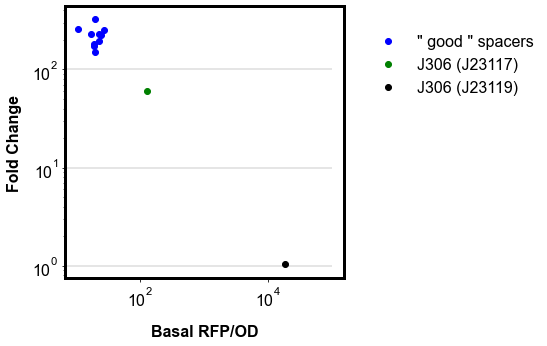

In [316]:
from adjustText import adjust_text

plt.figure(figsize = (5,5))

plt.errorbar(x=M(m0(lbls[:9])),y=R(lbls[:9]), color = 'b', label = '" good " spacers', fmt ='o')
#plt.errorbar(x=m0(lbls[9:11])-m0(['J2']),y=(m200(lbls[9:11])-m0(['J2']))/(m0(lbls[9:11])-m0(['J2'])), color = 'r', label = '" bad " spacers',fmt ='o')
plt.errorbar(x=m0(['YFB'])-m0(['J2']),y=(m200(['YFB'])-m0(['J2']))/(m0(['YFB'])-m0(['J2'])),color = 'b',fmt ='o')
plt.errorbar(x=m0(['J3'])-m0(['J2']),y=(m200(['J3'])-m0(['J2']))/(m0(['J3'])-m0(['J2'])), label = 'J306 (J23117)', color = 'g',fmt ='o')
plt.errorbar(x=m0(['119'])-m0(['J2']),y=(m200(['119'])-m0(['J2']))/(m0(['119'])-m0(['J2'])), label = 'J306 (J23119)',fmt ='o', color = 'k')

plt.legend(frameon=False, bbox_to_anchor=(1.05, .95))
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Fold Change', labelpad = ypad)
plt.xlabel('Basal RFP/OD', labelpad = xpad)
#plt.ylim(plt.gca().get_xlim())
#plt.gca().set_aspect(1./plt.gca().get_data_ratio())
#plt.xlim(plt.gca().get_xlim())

lim = 1e5
plt.plot([0,lim],2*[lim/lim ],'k-', alpha = 0.1)
plt.plot([0,lim],2*[lim*10/lim], 'k-', alpha = 0.1)
plt.plot([0,lim],2*[lim*100/lim], 'k-', alpha = 0.1)

#texts = [plt.text(m0[i]-m0[-2], (m200[i]-m0[-2])/(m0[i]-m0[-2]), lbls[i], ha='center', va='center',size = 12) for i in range(len(lbls))]
#adjust_text(texts, force_text = (3,3), force_points = (2,-2), force_objects = (0.0,0.0), arrowprops=dict(arrowstyle='-', color='gray', alpha = 0.1))


Text(0.5, 0, 'Basal RFP/OD')

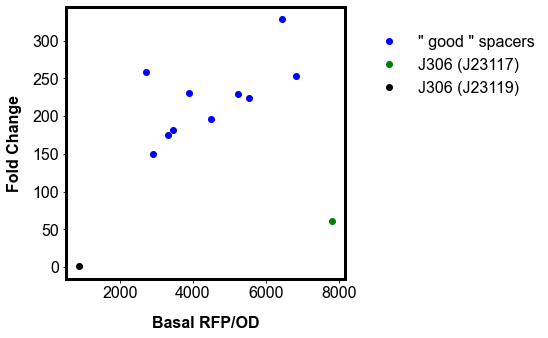

In [250]:
from adjustText import adjust_text

plt.figure(figsize = (5,5))

plt.errorbar(x=M(m200(lbls[:9]))-M(m0(lbls[:9])),y=R(lbls[:9]), color = 'b', label = '" good " spacers', fmt ='o')
plt.errorbar(x=(m200(['YFB'])-m0(['J2']))-(m0(['YFB'])-m0(['J2'])),y=(m200(['YFB'])-m0(['J2']))/(m0(['YFB'])-m0(['J2'])),color = 'b',fmt ='o')
plt.errorbar(x=(m200(['J3'])-m0(['J2']))-(m0(['J3'])-m0(['J2'])),y=(m200(['J3'])-m0(['J2']))/(m0(['J3'])-m0(['J2'])), label = 'J306 (J23117)', color = 'g',fmt ='o')
plt.errorbar(x=(m200(['119'])-m0(['J2']))-(m0(['119'])-m0(['J2'])),y=(m200(['119'])-m0(['J2']))/(m0(['119'])-m0(['J2'])), label = 'J306 (J23119)',fmt ='o', color = 'k')

plt.legend(frameon=False, bbox_to_anchor=(1.05, .95))
plt.ylabel('Fold Change', labelpad = ypad)
plt.xlabel('Basal RFP/OD', labelpad = xpad)
#plt.ylim(plt.gca().get_xlim())
#plt.gca().set_aspect(1./plt.gca().get_data_ratio())
#plt.xlim(plt.gca().get_xlim())

#texts = [plt.text(m0[i]-m0[-2], (m200[i]-m0[-2])/(m0[i]-m0[-2]), lbls[i], ha='center', va='center',size = 12) for i in range(len(lbls))]
#adjust_text(texts, force_text = (3,3), force_points = (2,-2), force_objects = (0.0,0.0), arrowprops=dict(arrowstyle='-', color='gray', alpha = 0.1))


8

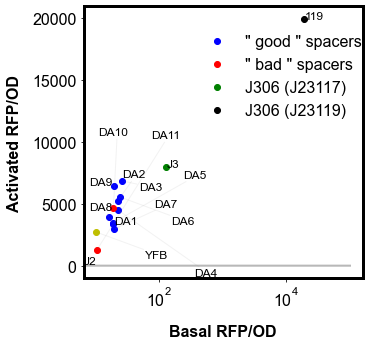

In [262]:
from adjustText import adjust_text

plt.figure(figsize = (5,5))

plt.errorbar(x=M(m0(lbls[:9])),y=M(m200(lbls[:9])), color = 'b', label = '" good " spacers', fmt ='o')
plt.errorbar(x=m0(lbls[9:11])-m0(['J2']),y=(m200(lbls[9:11])-m0(['J2'])), color = 'r', label = '" bad " spacers',fmt ='o')
plt.errorbar(x=m0(['YFB'])-m0(['J2']),y=(m200(['YFB'])-m0(['J2'])),color = 'y',fmt ='o')
plt.errorbar(x=m0(['J3'])-m0(['J2']),y=(m200(['J3'])-m0(['J2'])), label = 'J306 (J23117)', color = 'g',fmt ='o')
plt.errorbar(x=m0(['119'])-m0(['J2']),y=(m200(['119'])-m0(['J2'])), label = 'J306 (J23119)',fmt ='o', color = 'k')

plt.legend(frameon=False, bbox_to_anchor=(1.05, .95))
plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Activated RFP/OD', labelpad = ypad)
plt.xlabel('Basal RFP/OD', labelpad = xpad)
#plt.ylim(plt.gca().get_xlim())
#plt.gca().set_aspect(1./plt.gca().get_data_ratio())
#plt.xlim(plt.gca().get_xlim())

lim = 1e5
plt.plot([0,lim],2*[lim/lim ],'k-', alpha = 0.1)
plt.plot([0,lim],2*[lim*10/lim], 'k-', alpha = 0.1)
plt.plot([0,lim],2*[lim*100/lim], 'k-', alpha = 0.1)

texts = [plt.text(m0([i])-m0(['J2']), (m200([i])-m0(['J2'])), i, ha='center', va='center',size = 12) for i in lbls]
adjust_text(texts, force_text = (3,3), force_points = (2,-2), force_objects = (0.0,0.0), arrowprops=dict(arrowstyle='-', color='gray', alpha = 0.1))


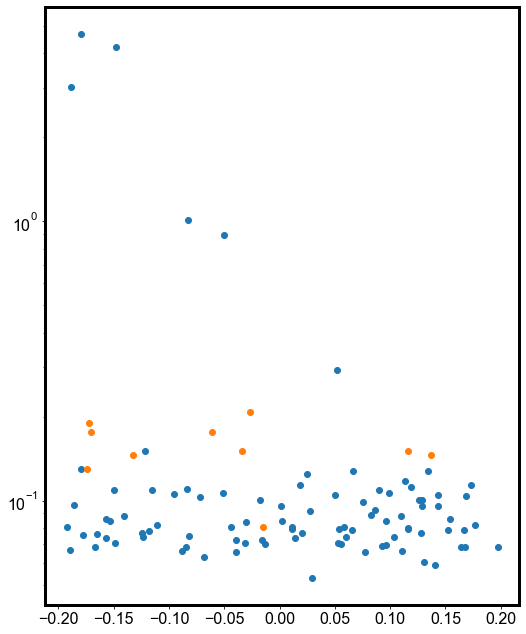

In [357]:
plt.scatter((np.random.rand(len(nY_E[1]))-0.5)/2.5,nY_E[1])
plt.scatter((np.random.rand(len(new_basal))-0.5)/2.5,new_basal)

plt.yscale('log')

Text(0.5, 0, 'Norm Basal RFP/OD')

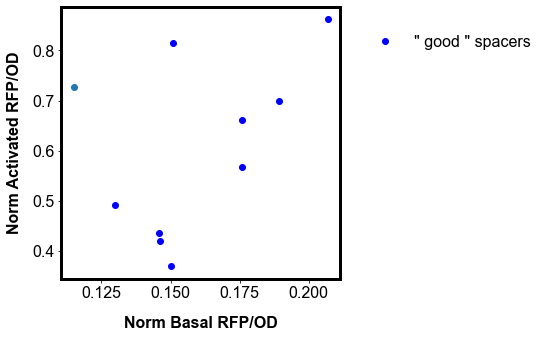

In [347]:
from adjustText import adjust_text

plt.figure(figsize = (5,5))

plt.errorbar(x=M(m0(lbls[:9]))/M(m0(['J3'])),y=M(m200(lbls[:9]))/M(m200(['J3'])), color = 'b', label = '" good " spacers', fmt ='o')
plt.scatter(0.11512,0.72754)
plt.legend(frameon=False, bbox_to_anchor=(1.05, .95))
plt.ylabel('Norm Activated RFP/OD', labelpad = ypad)
plt.xlabel('Norm Basal RFP/OD', labelpad = xpad)
#plt.ylim(plt.gca().get_xlim())
#plt.gca().set_aspect(1./plt.gca().get_data_ratio())
#plt.xlim(plt.gca().get_xlim())

#texts = [plt.text(m0[i]-m0[-2], (m200[i]-m0[-2])/(m0[i]-m0[-2]), lbls[i], ha='center', va='center',size = 12) for i in range(len(lbls))]
#adjust_text(texts, force_text = (3,3), force_points = (2,-2), force_objects = (0.0,0.0), arrowprops=dict(arrowstyle='-', color='gray', alpha = 0.1))


In [343]:
M(m200(lbls[:9]))/M(m200(['J3']))

array([0.49310021, 0.66159129, 0.8620537 , 0.5674659 , 0.43629703,
       0.6990108 , 0.36973022, 0.42076698, 0.81469035])

In [337]:
0.115128407
0.727542558


array([0.12977336, 0.17574354, 0.20683484, 0.17585728, 0.14572917,
       0.18925923, 0.15003323, 0.14617836, 0.15082748, 0.08049282])

In [272]:
new_basal = M(m0(lbls[:9]))/(m0(['J3'])-m0(['J2']))
new_basal = np.append(new_basal, (m0(['YFB'])-m0(['J2']))/(m0(['J3'])-m0(['J2'])))

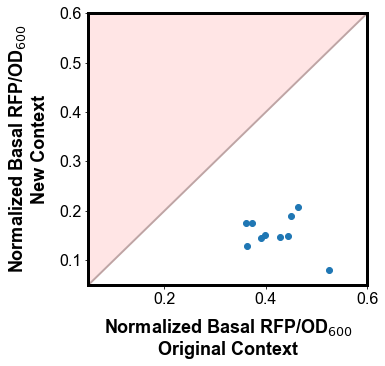

In [329]:
plt.figure(figsize = (5,5))
plt.scatter(og_basal,new_basal)
#plt.scatter(1,1)
#plt.xscale('log')
#plt.yscale('log')
plt.ylim([0.05,0.6])
#plt.gca().set_aspect(1./plt.gca().get_data_ratio())
plt.xlim([0.05,0.6])
plt.plot([0.05,0.6],[0.05,0.6],'k', alpha = 0.25)

plt.xlabel('Normalized Basal RFP/OD$_{600}$\nOriginal Context', labelpad = ypad, size = 18, weight = 'bold')
plt.ylabel('Normalized Basal RFP/OD$_{600}$\nNew Context', labelpad = ypad, size = 18, weight = 'bold')

plt.fill([0.05,0.05,0.6], [0.05,0.6,0.6], color = 'r',alpha = 0.1)
plt.fill([0.05,0.6,0.6], [0.05,0.6,0.6], color = 'g',alpha = 0.1)

# plt.annotate("", xy=(0.425, 0.4), xytext=(0.425, 0.225),
#              arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color = 'k', lw = 1))

In [6]:
lbls = list(exps)[15:-1]
m0 = np.array([get_ratio(exps[l],'0aTc').mean() for l in lbls])
s0 = np.array([get_ratio(exps[l],'0aTc').mean() for l in lbls])

In [114]:
path = 'activatable promoters/ecoli/soxbox/'
(_,_,filenames) = list(walk(path))[0]

read_OD = lambda f: pd.read_csv(path+f, delimiter  = '\t', skiprows = 52, index_col = (13,0)).loc['600'].set_index('Unnamed: 0')
OD = {f[:-4] : read_OD(f) for f in filenames if f[-3:] == 'txt'}

read_RFP= lambda f: pd.read_csv(path+f, delimiter  = '\t', skiprows = 52, index_col = (13,0)).loc['GFP+RFP:540/35,600/40'].set_index('Unnamed: 0').set_index(OD[f[:-4]].index)
RFP = {f[:-4] : read_RFP(f) for f in filenames if f[-3:] == 'txt'}

plate = pd.read_csv(path+'211025-soxbox_LAYOUT.csv', index_col = 0, dtype = str) # reads plate layout

# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append((i[0], i[1]))
            
get_data = lambda X, df, lbl: np.array([df[lbl].loc[x] for x in X])
get_ratio = lambda X, lbl: get_data(X,RFP,lbl)/get_data(X,OD,lbl)

In [115]:
sorted_lbls = np.sort([*exps.keys()])

<ipython-input-116-e29f2f967f66>:21: RuntimeWarning: invalid value encountered in double_scalars
  m.append((m200)/(m0))
<ipython-input-116-e29f2f967f66>:22: RuntimeWarning: divide by zero encountered in double_scalars
  s.append(m[-1]*np.sqrt( (s200/m200)**2 + (s0/m0)**2 ))


([<matplotlib.axis.XTick at 0x20388dc8940>,
 [Text(0, 0, '119_2+'),
  Text(1, 0, '119_2-'),
  Text(2, 0, 'J2_2+'),
  Text(3, 0, 'J2_2-'),
  Text(4, 0, 'J3_1+'),
  Text(5, 0, 'J3_1-'),
  Text(6, 0, 'J3_2+'),
  Text(7, 0, 'J3_2-'),
  Text(8, 0, 'anti_1+'),
  Text(9, 0, 'anti_1-'),
  Text(10, 0, 'anti_2+'),
  Text(11, 0, 'anti_2-'),
  Text(12, 0, 'opt_1+'),
  Text(13, 0, 'opt_1-'),
  Text(14, 0, 'opt_2+'),
  Text(15, 0, 'opt_2-'),
  Text(16, 0, 'soxs_1+'),
  Text(17, 0, 'soxs_1-'),
  Text(18, 0, 'soxs_2+'),
  Text(19, 0, 'soxs_2-')])

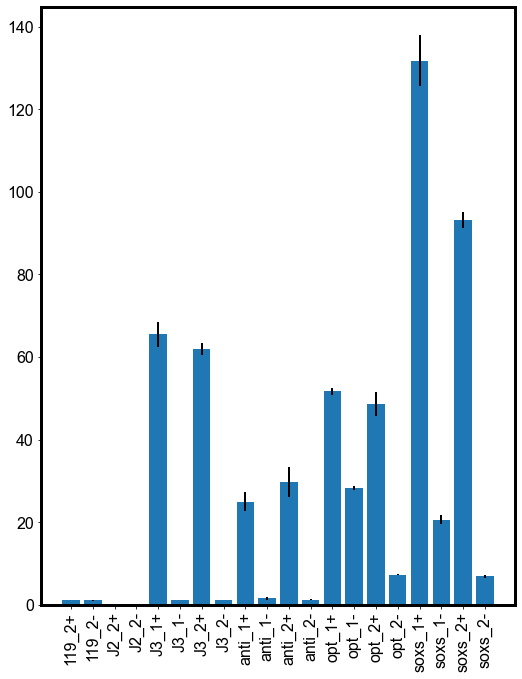

In [116]:
m = []
s = []
for l in sorted_lbls:
    if '+' in l: 
        bm200 = get_ratio(exps['J2_2+'],'200nM').mean()
        bs200 = get_ratio(exps['J2_2+'],'200nM').std()
        bm0 = get_ratio(exps['J2_2+'],'0nM').mean()
        bs0 = get_ratio(exps['J2_2+'],'0nM').std()
        
    else:
        bm200 = get_ratio(exps['J2_2-'],'200nM').mean()
        bs200 = get_ratio(exps['J2_2-'],'200nM').std()
        bm0 = get_ratio(exps['J2_2-'],'0nM').mean()
        bs0 = get_ratio(exps['J2_2-'],'0nM').std()

    m200 = get_ratio(exps[l],'200nM').mean()-bm200
    s200 = (get_ratio(exps[l],'200nM').std()**2 + bs200**2)**0.5
    m0 = get_ratio(exps[l],'0nM').mean()-bm0
    s0 = (get_ratio(exps[l],'0nM').std()**2 + bs0**2)**0.5
    
    m.append((m200)/(m0))
    s.append(m[-1]*np.sqrt( (s200/m200)**2 + (s0/m0)**2 ))
    
m = np.array(m)
s = np.array(s)

plt.bar(np.arange(len(sorted_lbls)), m, yerr = s)
plt.xticks(np.arange(len(sorted_lbls)),sorted_lbls, rotation = 90)

Text(8.2, 20, 'J3: CGTCGTCTTGAAGTTGCGATTATAGA')

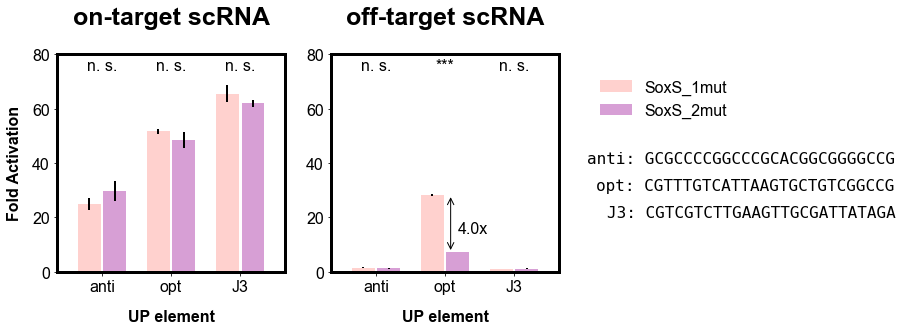

In [117]:
plt.figure(figsize=(9,4))
plt.subplot(121)
x = np.array([0,2.45,4.9])
xticks = [s[:-3] for s in sorted_lbls[[8,12,4]]]

plt.bar(x-0.45,m[[8,12,4]], yerr = s[[8,12,4]], color = '#ffa59e', alpha = 0.5)
plt.bar(x+0.45,m[[10,14,6]], yerr = s[[10,14,6]], color = '#b041ad', alpha = 0.5)

plt.ylabel('Fold Activation', labelpad = ypad)
plt.title('on-target scRNA', pad =xpad*2)
plt.xticks(x,xticks)
plt.xlabel('UP element', labelpad = xpad)
plt.ylim([0,80])
plt.xlim([-1.6,6.5])

put_pval(0, 0, stats.ttest_ind_from_stats(m[4:-4:4][1],s[4:-4:4][1],3,m[6:-4:4][1],s[6:-4:4][1],3, equal_var = 'False')[1], x, [49]*3, dh = 0.3, barh = .0, maxasterix = 3)
put_pval(1, 1, stats.ttest_ind_from_stats(m[4:-4:4][2],s[4:-4:4][2],3,m[6:-4:4][2],s[6:-4:4][2],3, equal_var = 'False')[1], x, [49]*3, dh = 0.3, barh = .0, maxasterix = 3)
put_pval(2, 2, stats.ttest_ind_from_stats(m[4:-4:4][0],s[4:-4:4][0],3,m[6:-4:4][0],s[6:-4:4][0],3, equal_var = 'False')[1], x, [49]*3, dh = 0.3, barh = .0, maxasterix = 3)

plt.subplot(122)
plt.bar(x-0.45,m[[9,13,5]], yerr = s[[9,13,5]], color = '#ffa59e', alpha = 0.5)
plt.bar(x+0.45,m[[11,15,7]], yerr = s[[11,15,7]], color = '#b041ad', alpha = 0.5)
#plt.ylabel('Fold Activation', labelpad = ypad)
plt.title('off-target scRNA', pad = xpad*2)
plt.xticks(x,xticks)
plt.xlabel('UP element', labelpad = xpad)
plt.ylim([0,80])
plt.xlim([-1.6,6.5])

plt.legend(['SoxS_1mut','SoxS_2mut'],frameon=False, bbox_to_anchor=(1.8, .95))
#plt.tight_layout()

put_pval(0, 0, stats.ttest_ind_from_stats(m[5:-4:4][1],s[5:-4:4][1],3,m[7:-4:4][1],s[7:-4:4][1],3, equal_var = 'False')[1], x, [49]*3, dh = 0.3, barh = .0, maxasterix = 3)
put_pval(1, 1, stats.ttest_ind_from_stats(m[5:-4:4][2],s[5:-4:4][2],3,m[7:-4:4][2],s[7:-4:4][2],3, equal_var = 'False')[1], x, [49]*3, dh = 0.3, barh = .0, maxasterix = 3)
put_pval(2, 2, stats.ttest_ind_from_stats(m[5:-4:4][0],s[5:-4:4][0],3,m[7:-4:4][0],s[7:-4:4][0],3, equal_var = 'False')[1], x, [49]*3, dh = 0.3, barh = .0, maxasterix = 3)

plt.annotate("", xy=(2.65, m[5:-4:4][2]), xytext=(2.65, m[7:-4:4][2]),
             arrowprops=dict(arrowstyle="<->", connectionstyle="arc3", color = 'k', lw = 1))
plt.text(2.6+0.3, m[5:-4:4][2]/2, '{x:.{d}f}x'.format(x=np.round(m[5:-4:4][2]/m[7:-4:4][2]),d=1))

plt.text(7.5, 40, 'anti: GCGCCCCGGCCCGCACGGCGGGGCCG', family = 'monospace')
plt.text(7.8, 30, 'opt: CGTTTGTCATTAAGTGCTGTCGGCCG', family = 'monospace')
plt.text(8.2, 20, 'J3: CGTCGTCTTGAAGTTGCGATTATAGA', family = 'monospace')


In [18]:
sorted_lbls[[5,7]]

array(['J3_1-', 'J3_2-'], dtype='<U7')

In [19]:
m[[5,7]]

array([1.07530461, 1.16128712])

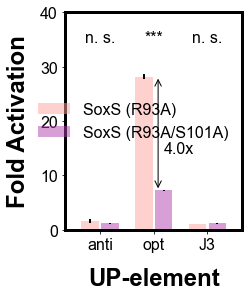

In [160]:
plt.figure(figsize=(7,4))

plt.subplot(122)
plt.bar(x-0.45,m[[9,13,5]], yerr = s[[9,13,5]], color = '#ffa59e', alpha = 0.5)
plt.bar(x+0.45,m[[11,15,7]], yerr = s[[11,15,7]], color = '#b041ad', alpha = 0.5)
plt.ylabel('Fold Activation', labelpad = ypad, fontsize = 24)
# plt.title('off-target scRNA', pad = xpad*2)
plt.xticks(x,xticks)
plt.xlabel('UP-element', labelpad = xpad, fontsize = 24)
plt.ylim([0,40])
plt.xlim([-1.6,6.5])

plt.legend(['SoxS (R93A)','SoxS (R93A/S101A)'],frameon=False)
#plt.tight_layout()

put_pval(0, 0, stats.ttest_ind_from_stats(m[5:-4:4][1],s[5:-4:4][1],3,m[7:-4:4][1],s[7:-4:4][1],3, equal_var = 'False')[1], x, [22]*3, dh = 0.3, barh = .0, maxasterix = 3)
put_pval(1, 1, stats.ttest_ind_from_stats(m[5:-4:4][2],s[5:-4:4][2],3,m[7:-4:4][2],s[7:-4:4][2],3, equal_var = 'False')[1], x, [22]*3, dh = 0.3, barh = .0, maxasterix = 3)
put_pval(2, 2, stats.ttest_ind_from_stats(m[5:-4:4][0],s[5:-4:4][0],3,m[7:-4:4][0],s[7:-4:4][0],3, equal_var = 'False')[1], x, [22]*3, dh = 0.3, barh = .0, maxasterix = 3)

plt.annotate("", xy=(2.65, m[5:-4:4][2]), xytext=(2.65, m[7:-4:4][2]),
             arrowprops=dict(arrowstyle="<->", connectionstyle="arc3", color = 'k', lw = 1))
plt.text(2.6+0.3, m[5:-4:4][2]/2, '{x:.{d}f}x'.format(x=np.round(m[5:-4:4][2]/m[7:-4:4][2]),d=1))

# plt.text(7.5, 20, 'anti: GCGCCCCGGCCCGCACGGCGGGGCCG', family = 'monospace')
# plt.text(7.8, 15, 'opt: CGTTTGTCATTAAGTGCTGTCGGCCG', family = 'monospace')
# plt.text(8.2, 10, 'J3: CGTCGTCTTGAAGTTGCGATTATAGA', family = 'monospace')

plt.savefig('figures/Fig2D1.svg')

In [128]:
path = 'activatable promoters/ecoli/soxbox/lib/'
(_,_,filenames) = list(walk(path))[0]

read_OD = lambda f: pd.read_csv(path+f, delimiter  = '\t', skiprows = 52, index_col = (13,0)).loc['600'].set_index('Unnamed: 0')
OD = {f[:-4] : read_OD(f) for f in filenames if f[-3:] == 'txt'}

read_RFP= lambda f: pd.read_csv(path+f, delimiter  = '\t', skiprows = 52, index_col = (13,0)).loc['GFP+RFP:540/35,600/40'].set_index('Unnamed: 0').set_index(OD[f[:-4]].index)
RFP = {f[:-4] : read_RFP(f) for f in filenames if f[-3:] == 'txt'}

plate = pd.read_csv(path+'211029-lib_LAYOUT.csv', index_col = 0, dtype = str) # reads plate layout

# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append((i[0], i[1]))
            
get_data = lambda X, df, lbl: np.array([df[lbl].loc[x] for x in X])
get_ratio = lambda X, lbl: get_data(X,RFP,lbl)/get_data(X,OD,lbl)

In [129]:
b = 54.428
FA = (get_ratio(exps['lib'],'3N_OFF_200')-b) / (get_ratio(exps['lib'],'3N_OFF_0')-b)

aFA = (get_ratio(exps['anti_2-'],'3N_OFF_200')-b) / (get_ratio(exps['anti_2-'],'3N_OFF_0')-b)
oFA = (get_ratio(exps['opt_2-'],'3N_OFF_200')-b) / (get_ratio(exps['opt_2-'],'3N_OFF_0')-b)

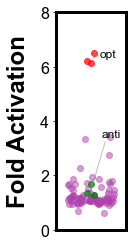

In [158]:
X = (np.random.rand(len(FA))-0.5)/1.5

plt.figure(figsize=(1.25,4))
plt.scatter(X,FA, color = '#b041ad', alpha = 0.5)
plt.scatter([-0.05,0,0.05],oFA, color = 'g', alpha = 0.7)
plt.scatter([-0.05,0,0.05],aFA, color = 'r', alpha = 0.7)
plt.ylabel('Fold Activation', labelpad = ypad, fontsize = 24)

texts=[]
texts.append(plt.text(0, aFA.mean(), 'opt', ha='center', va='center',size = 12))
texts.append(plt.text(0, oFA.mean(), 'anti', ha='center', va='center',size = 12))
adjust_text(texts, force_points = (30,30), arrowprops=dict(arrowstyle='-', color='gray', alpha = 0.5))
plt.ylim([0.0,8])
plt.xlim([-0.5, 0.5])
plt.xticks([])
plt.savefig('figures/Fig2D2.svg')

In [306]:
np.round(np.sum(FA<=(oFA.mean()))/len(FA),2)
np.round(np.sum(FA<=(oFA.mean()+2*oFA.std()))/len(FA),2)

0.91

In [308]:
oFA.mean()

1.447986005072023

In [307]:
oFA.mean()+2*oFA.std()

1.7844945095861469

In [353]:
path = 'activatable promoters/ecoli/UP/reselection/'
(_,_,filenames) = list(walk(path))[0]

read_OD = lambda f: pd.read_csv(path+f, delimiter  = '\t', skiprows = 52, index_col = (13,0)).loc['600'].set_index('Unnamed: 0')
OD = {f[:-4] : read_OD(f) for f in filenames if f[-3:] == 'txt'}

read_RFP= lambda f: pd.read_csv(path+f, delimiter  = '\t', skiprows = 52, index_col = (13,0)).loc['GFP+RFP:540/35,600/40'].set_index('Unnamed: 0').set_index(OD[f[:-4]].index)
RFP = {f[:-4] : read_RFP(f) for f in filenames if f[-3:] == 'txt'}

plate = pd.read_csv(path+'211029-plate_LAYOUT.csv', index_col = 0, dtype = str) # reads plate layout

# go through the plate layout and identify replicates, make a dictionary of experiments with list of replicate wells
labels = pd.unique(np.concatenate(plate.values))
exps = {}
xlbl = []
for l in labels:
    if type(l) is str:
        xlbl.append(l)
        index = plate[plate.isin([l])].stack().index
        exps[l] = []
        for i in index:
            exps[l].append((i[0], i[1]))
            
get_data = lambda X, df, lbl: np.array([df[lbl].loc[x] for x in X])
get_ratio = lambda X, lbl: get_data(X,RFP,lbl)/get_data(X,OD,lbl)

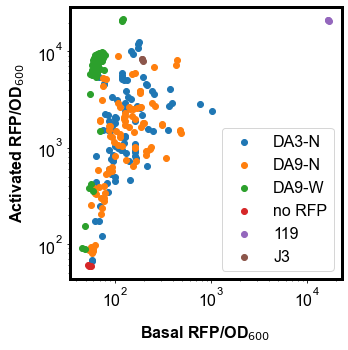

In [253]:
b0 = get_ratio(exps['control'],'3N_ON_0')
b200 = get_ratio(exps['control'],'3N_ON_200')

max0 = get_ratio(exps['control'],'9W_ON_0')
max200 = get_ratio(exps['control'],'9W_ON_200')

J30 = get_ratio(exps['control'],'9N_ON_0')
J3200 = get_ratio(exps['control'],'9N_ON_200')

plt.figure(figsize=(5,5))
plt.scatter(get_ratio(exps['lib'],'3N_ON_0'),get_ratio(exps['lib'],'3N_ON_200'))
plt.scatter(get_ratio(exps['lib'],'9N_ON_0'),get_ratio(exps['lib'],'9N_ON_200'))
plt.scatter(get_ratio(exps['lib'],'9W_ON_0'),get_ratio(exps['lib'],'9W_ON_200'))
plt.scatter(b0,b200)
plt.scatter(max0,max200)
plt.scatter(J30,J3200)

plt.legend(['DA3-N','DA9-N','DA9-W', 'no RFP','119','J3'])
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Activated RFP/OD$_{600}$', labelpad = ypad)
plt.xlabel('Basal RFP/OD$_{600}$', labelpad = xpad)
plt.gca().set_aspect(1./plt.gca().get_data_ratio())

57

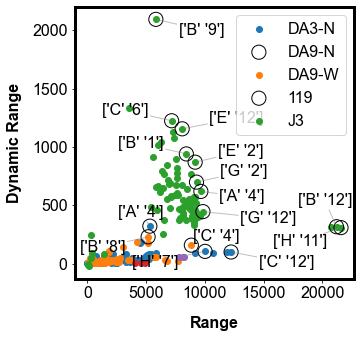

In [256]:
fDR = lambda B,A: (A-b200.mean()) / (B-b0.mean()+b0.std())
fR = lambda B,A: (A-b200.mean()) - (B-b0.mean()+b0.std())
pareto2 = lambda A, B: [~(np.any((A>a) & (B>b))) for a,b in zip(A,B)]

texts = []
best = {}
plt.figure(figsize=(5,5))
for l in ['3N_ON_','9N_ON_','9W_ON_']:
    R = fR(get_ratio(exps['lib'],l+'0'),get_ratio(exps['lib'],l+'200'))
    DR = fDR(get_ratio(exps['lib'],l+'0'),get_ratio(exps['lib'],l+'200'))
    plt.scatter(R, DR)
    best[l[:2]] = pareto2(DR,R)
    plt.scatter(R[best[l[:2]]],DR[best[l[:2]]], color = 'k', alpha = 1, s = 200,facecolors='none')
    for ll, p,k in zip(np.array(exps['lib']),best[l[:2]], range(93)):
        if p:
            texts.append(plt.text(R[k], DR[k], str(ll)))
            #print(l)
            #print(str(ll))
            #print([R[k],DR[k]])
        
plt.scatter(fR(max0,max200), fDR(max0,max200))
plt.scatter(fR(J30,J3200), fDR(J30,J3200))

plt.legend(['DA3-N','DA9-N','DA9-W','119','J3'])
plt.ylabel('Dynamic Range', labelpad = ypad)
plt.xlabel('Range', labelpad = xpad)

#plt.xlim((-50, 25060.76544007391/2))
#plt.ylim((-5, 1985.92886691264357))
adjust_text(texts, force_points = (20,2), arrowprops=dict(arrowstyle='-', color='gray', alpha = 0.5))


In [259]:
fDR(J30,J3200).mean()

57.89052494844275

In [173]:
l = '9W_ON_'
np.sort(DR(get_ratio(exps['lib'],l+'0'),get_ratio(exps['lib'],l+'200')))

array([-1.28817185e+03, -1.71909606e+01, -6.11482528e+00, -3.62030413e+00,
        5.88029487e+01,  9.24837369e+01,  1.44381583e+02,  2.72807502e+02,
        3.15531285e+02,  3.21658821e+02,  3.23825101e+02,  3.54699538e+02,
        3.83135317e+02,  4.01084348e+02,  4.04748948e+02,  4.10637318e+02,
        4.12041223e+02,  4.13714297e+02,  4.18642391e+02,  4.29172350e+02,
        4.29318959e+02,  4.29684469e+02,  4.35628361e+02,  4.37450964e+02,
        4.39009040e+02,  4.39966517e+02,  4.45318770e+02,  4.48783686e+02,
        4.49412248e+02,  4.55521363e+02,  4.70481690e+02,  4.70636583e+02,
        4.70886785e+02,  4.75775634e+02,  4.80339831e+02,  4.81408673e+02,
        4.98692328e+02,  4.99971440e+02,  5.05438187e+02,  5.17806086e+02,
        5.21913311e+02,  5.27318395e+02,  5.32310307e+02,  5.35473487e+02,
        5.36808989e+02,  5.52270704e+02,  5.64079533e+02,  5.75724100e+02,
        5.77060252e+02,  5.78113534e+02,  6.08816728e+02,  6.12885100e+02,
        6.31090724e+02,  

In [200]:
(get_ratio(exps['lib'],'9W_ON_200')-b200.mean())[17]/(get_ratio(exps['lib'],'9W_ON_0')-b0.mean()+b0.std())[17]

2093.7556647715064

In [179]:
 np.argsort(DR(get_ratio(exps['lib'],'9W_ON_0'),get_ratio(exps['lib'],'9W_ON_200')))

array([22, 68,  4,  5, 33, 72, 29, 78, 91, 66, 20, 69, 36, 40, 55, 41, 64,
       51, 65, 49, 59, 57, 37, 85, 54, 73, 48, 61, 60, 16, 86, 83, 84, 39,
       80, 90, 35, 34, 88, 21,  6, 58,  1, 31, 43, 76, 24, 32, 38, 27, 18,
       87, 28, 30, 10, 74, 44, 13,  2, 45, 42,  0, 75, 62, 89, 67,  8, 47,
       70, 19, 23, 25, 53, 79, 63, 15, 81, 14,  3, 82, 46, 92, 52,  9, 77,
       71, 11,  7, 56, 12, 26, 50, 17], dtype=int64)

In [182]:
DR(get_ratio(exps['lib'],'9W_ON_0'),get_ratio(exps['lib'],'9W_ON_200'))[26]

1683.2979097861753

In [191]:
b200.std()

0.8441378976252867

In [202]:
(get_ratio(exps['lib'],'9W_ON_0')-b0.mean()+b0.std())[17]

2.7845175582162653

Text(0.5, 0, 'Range')

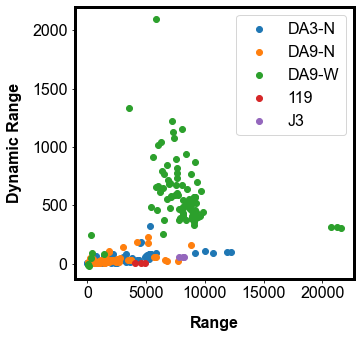

In [321]:
fDR = lambda B,A: (A-b200.mean()) / (B-b0.mean()+b0.std())
fR = lambda B,A: (A-b200.mean()) - (B-b0.mean()+b0.std())
pareto2 = lambda A, B: [~(np.any((A>a) & (B>b))) for a,b in zip(A,B)]

texts = []
best = {}
plt.figure(figsize=(5,5))
for l in ['3N_ON_','9N_ON_','9W_ON_']:
    R = fR(get_ratio(exps['lib'],l+'0'),get_ratio(exps['lib'],l+'200'))
    DR = fDR(get_ratio(exps['lib'],l+'0'),get_ratio(exps['lib'],l+'200'))
    plt.scatter(R, DR)
    best[l[:2]] = pareto2(DR,R)
        
plt.scatter(fR(max0,max200), fDR(max0,max200))
plt.scatter(fR(J30,J3200), fDR(J30,J3200))

plt.legend(['DA3-N','DA9-N','DA9-W','119','J3'])
plt.ylabel('Dynamic Range', labelpad = ypad)
plt.xlabel('Range', labelpad = xpad)

#plt.xlim((-50, 25060.76544007391/2))
#plt.ylim((-5, 1985.92886691264357))

<ipython-input-236-dc8ddc2c4e8f>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['$10^{x}$'.replace('x',str(int(y))) for y in ax.get_yticks()])


Text(0, 0.5, 'Relative RFP/OD$_{600}$')

posx and posy should be finite values
posx and posy should be finite values


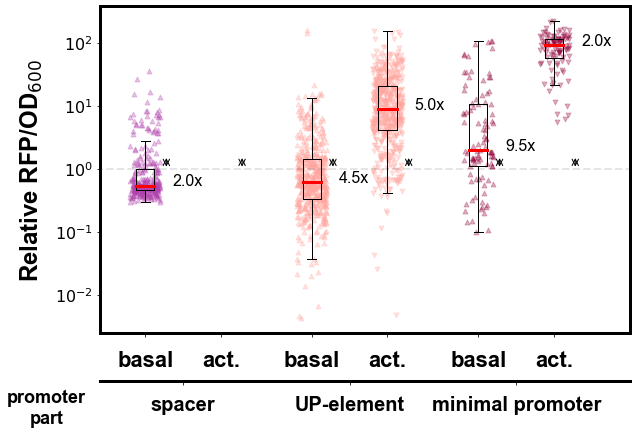

In [236]:
Y = [rel_spacers_libs_0, [0]*20, rel_UP_libs_0, rel_UP_libs_200, rel_promoter_libs_0, rel_promoter_libs_200]
Y = list(map(np.array,Y))
Y = [np.log10(y[y>0]) for y in Y]
X = [(np.random.rand(len(y))-0.5)/2 for y in Y]

colors = ['#b041ad', '#b041ad','#ffa59e','#ffa59e','#93003a','#93003a']
alphas = [0.3]*6
markers = ['^','v']*3

xlocs = [0,1.25,2.75,4,5.5,6.75]
plt.figure(figsize = (9.5,6))
[plt.scatter(x+z,y,marker=m, color = c,alpha =a, s = 24) for x,y,z,c,a,m in zip(X,Y,xlocs,colors,alphas,markers)]
bp = plt.boxplot(np.array(Y,dtype=object).T,positions = xlocs, showfliers=False, widths = 0.3)
ax = plt.gca()

medians = []
for median,c,box in zip(bp['medians'],colors,bp['boxes']): 
    median.set(color ='r', linewidth = 3)
    y = median.get_ydata()[0]
    x = median.get_xdata()[1]
    medians.append(median.get_ydata()[0])
    IQR = (10**box.get_data()[1].max() / 10**box.get_data()[1].min())
    
    ax.annotate("", xy=(x+0.2, 0), xytext=(x+0.2, 0.2),
                  arrowprops=dict(arrowstyle="<->", connectionstyle="arc3", color = 'k', lw = 1))
    ax.text(x+0.3,y, '{x:.{d}f}x'.format(x=np.round(IQR*2)/2,d=1))

ax.set_xlim([-.75,8])
ax.set_yticklabels(['$10^{x}$'.replace('x',str(int(y))) for y in ax.get_yticks()])
plt.plot([-1,8],[0,0],'k--', alpha =0.1)
#plt.ylim([0.02,95])  
#plt.yscale('log')

ylocs = [19]*6
# put_pval(0, 1, stats.median_test(Y[0],Y[1])[1], xlocs, ylocs, dh = 0.3, barh = .05, maxasterix = 3)
# put_pval(2, 3, stats.median_test(Y[2],Y[3])[1], xlocs, ylocs, dh = 0.3, barh = .05, maxasterix =3)
# put_pval(4, 5, stats.median_test(Y[4],Y[5])[1], xlocs, ylocs, dh = 0.3, barh = .05, maxasterix =3)

#Second X-axis
ax2 = ax.twiny(); ax2.set_xlim(ax.get_xlim())
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.spines["bottom"].set_position(("axes", -0.15))

ax.tick_params(axis='x', which='major', pad=14)
#ax.set_xlabel('UP element\nbasal', size = 18)
ax.xaxis.set_label_coords(-0.10, -0.03)
ax.set_xticklabels(labels = ['basal','act.']*3, size = 22, weight = 'bold')

ax2.tick_params(axis='x', which='major', pad=10)
ax2.set_xlabel('promoter\npart', size = 18)
ax2.xaxis.set_label_coords(-0.10, -0.17)
ax2.set_xticks([(x2-x1)/2+x1 for x1,x2 in zip(xlocs[::2],xlocs[1::2])])
ax2.set_xticklabels(labels = ['spacer', 'UP-element','minimal promoter'], size = 20, weight = 'bold')

ax.set_ylabel('Relative RFP/OD$_{600}$', labelpad = ypad, size = 24, weight = 'bold')
#plt.savefig('figures/Fig2C.svg')

<ipython-input-292-ce8d7b69deea>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['$10^{x}$'.replace('x',str(int(y))) for y in ax.get_yticks()])


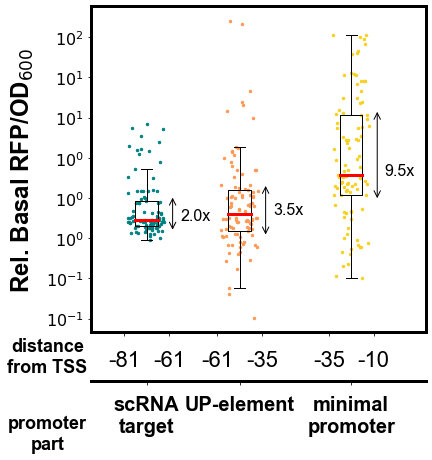

In [292]:
Y = [rel_spacers_libs_0, rel_UP_libs_0, rel_promoter_libs_0]
Y = list(map(np.array,Y))
Y = [np.random.choice(np.log10(y[y>0]),98, replace = False) for y in Y]
X = [(np.random.rand(len(y))-0.5)/2 for y in Y]

colors = ['#008080ff', '#ff9955ff','#f8d020ff']
alphas = [1]*3
markers = ['.']*3

xlocs = [0,1.25,2.75]
plt.figure(figsize = (6,6))
[plt.scatter(x+z,y,marker=m, color = c,alpha =a, s = 24) for x,y,z,c,a,m in zip(X,Y,xlocs,colors,alphas,markers)]
bp = plt.boxplot(np.array(Y,dtype=object).T,positions = xlocs, showfliers=False, widths = 0.3)
ax = plt.gca()

medians = []
for median,c,box in zip(bp['medians'],colors,bp['boxes']): 
    median.set(color ='r', linewidth = 3)
    y = median.get_ydata()[0]
    x = median.get_xdata()[1]
    medians.append(median.get_ydata()[0])
    IQR = (10**box.get_data()[1].max() / 10**box.get_data()[1].min())
    
    ax.annotate("", xy=(x+0.2, box.get_data()[1].min()-0.07), xytext=(x+0.2, box.get_data()[1].max()+0.07),
                  arrowprops=dict(arrowstyle="<->", connectionstyle="arc3", color = 'k', lw = 1))
    ax.text(x+0.3,y, '{x:.{d}f}x'.format(x=np.round(IQR*2)/2,d=1))

ax.set_xlim([-.75,3.75])
ax.set_yticklabels(['$10^{x}$'.replace('x',str(int(y))) for y in ax.get_yticks()])
#plt.plot([-1,8],[0,0],'k--', alpha =0.1)
#plt.ylim([0.02,95])  
#plt.yscale('log')

ylocs = [19]*6
# put_pval(0, 1, stats.median_test(Y[0],Y[1])[1], xlocs, ylocs, dh = 0.3, barh = .05, maxasterix = 3)
# put_pval(2, 3, stats.median_test(Y[2],Y[3])[1], xlocs, ylocs, dh = 0.3, barh = .05, maxasterix =3)
# put_pval(4, 5, stats.median_test(Y[4],Y[5])[1], xlocs, ylocs, dh = 0.3, barh = .05, maxasterix =3)

#Second X-axis
ax2 = ax.twiny(); ax2.set_xlim(ax.get_xlim())
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.spines["bottom"].set_position(("axes", -0.15))

ax.tick_params(axis='x', which='major', pad=14)
ax.set_xlabel('distance\nfrom TSS', size = 18)
ax.xaxis.set_label_coords(-0.13, -0.015)
ax.set_xticks(sum([[x-0.3, x+0.3] for x in xlocs],[]))
ax.set_xticklabels(labels = ['-81','-61','-61','-35','-35','-10'], size = 22, weight = 'normal')

ax2.tick_params(axis='x', which='major', pad=10)
ax2.set_xlabel('promoter\npart', size = 18)
ax2.xaxis.set_label_coords(-0.13, -0.25)
ax2.set_xticks(xlocs)
ax2.set_xticklabels(labels = ['scRNA\ntarget', 'UP-element','minimal\npromoter'], size = 20, weight = 'bold', rotation = 0)

ax.set_ylabel('Rel. Basal RFP/OD$_{600}$', labelpad = ypad, size = 24, weight = 'bold')
plt.savefig('figures/rel_basal_parts.svg')

In [376]:
import logomaker

def OHE(seq):
    mapping = dict(zip("ACGT", range(4)))    
    seq2 = [mapping[i] for i in seq]
    return np.eye(4)[seq2]

In [378]:
# from Fontana 2020
Jorder = ['109','113','112','117','114','115','108','105','107','106','110','118','111']
Joff = [185.683405,210.830833,210.928365,390.127515,751.331572,1354.92535,2925.30127,3755.80275,4481.32113,6004.4285,8271.30438,15853.4529,20157.9851]
Jon = [249.081809,104.098588,106.684543,13996.8834,17893.9579,20930.2497,15255.2639,25883.8859,23427.1494,24739.2714,25655.8463,27187.2988,21541.0776]
JAR = [1.34143279,0.4937541,0.50578566,35.877714,23.8163263,15.4475298,5.21493772,6.89170534,5.22773278,4.12017087,3.10178964,1.71491339,1.06861264]
JAP = pd.DataFrame(np.array([Joff,Jon, JAR]).T,columns = ['J off m','J on m', 'J AR m'], index = Jorder)
JAP.index = JAP.index.map(lambda x: 'J23'+x)
#allAP = JAP.join(AP).sort_values('J off m')

In [526]:
seqs = {'J23119': 'TTGACAgctagctcagtcctaggTATAATgctagc',
'J23111': 'ttgacggctagctcagtcctaggtatagtgctagc',
'J23118': 'ttgacggctagctcagtcctaggtattgtgctagc',
'J23110': 'tttacggctagctcagtcctaggtacaatgctagc',
'J23106': 'tttacggctagctcagtcctaggtatagtgctagc',
'J23107': 'tttacggctagctcagccctaggtattatgctagc',
'J23105': 'tttacggctagctcagtcctaggtactatgctagc',
'J23108': 'ctgacagctagctcagtcctaggtataatgctagc',
'J23115': 'tttatagctagctcagcccttggtacaatgctagc',
'J23114': 'tttatggctagctcagtcctaggtacaatgctagc',
'J23117': 'ttgacagctagctcagtcctagggattgtgctagc',
'J23112': 'ctgatagctagctcagtcctagggattatgctagc',
'J23113': 'ctgatggctagctcagtcctagggattatgctagc',
'J23109': 'tttacagctagctcagtcctagggactgtgctagc'}

JAP['seq'] = list(JAP.index.map(lambda x: seqs[x].upper()[1:-7]))
JAP['ohe_seq'] = JAP['seq'].apply(OHE)

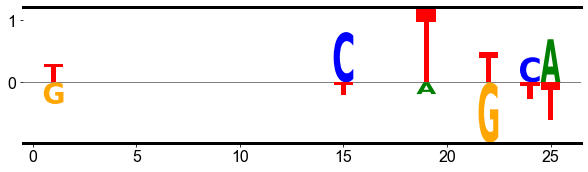

In [527]:
good = JAP[JAP['J AR m'] > 10]
bad = JAP[JAP['J off m'] <= 300]

a = pd.DataFrame((np.sum(np.stack(JAP['ohe_seq']),0)), columns = ['A','C','G','T'])
a = logomaker.transform_matrix(a,from_type='counts', to_type='probability')
g = pd.DataFrame((np.sum(np.stack(good['ohe_seq']),0)), columns = ['A','C','G','T'])
g = logomaker.transform_matrix(g,from_type='counts', to_type='probability')
b = pd.DataFrame((np.sum(np.stack(bad['ohe_seq']),0)), columns = ['A','C','G','T'])
b = logomaker.transform_matrix(b,from_type='counts', to_type='probability')

# logo = logomaker.Logo(p,stack_order='small_on_top', fade_probabilities=True)

logo = logomaker.Logo((g-b)/a, flip_below = False)
logo.style_spines(spines=['left', 'right'], visible=False)


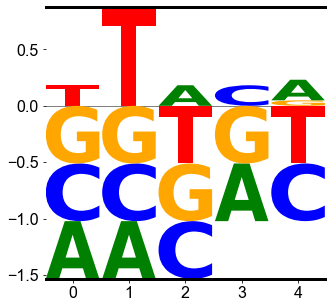

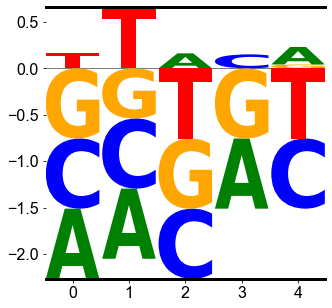

In [745]:
# pick -35

good = JAP[(JAP['J AR m'] >= 2.5) | (JAP['J off m'] <= 400)]
bad = JAP[(JAP['J AR m'] < 2.5)]

#good = JAP[JAP['J AR m'] > 15]

a = pd.DataFrame((np.sum(np.stack(JAP['ohe_seq']),0)), columns = ['A','C','G','T'])
a = logomaker.transform_matrix(a,from_type='counts', to_type='probability')
g = pd.DataFrame((np.sum(np.stack(good['ohe_seq']),0)), columns = ['A','C','G','T'])
g = logomaker.transform_matrix(g,from_type='counts', to_type='probability')
b = pd.DataFrame((np.sum(np.stack(bad['ohe_seq']),0)), columns = ['A','C','G','T'])
b = logomaker.transform_matrix(b,from_type='counts', to_type='probability')

# logo = logomaker.Logo(p,stack_order='small_on_top', fade_probabilities=True)

logo = logomaker.Logo((np.log(g/b)).iloc[:5], flip_below = False, figsize = (5,5))
logo.style_spines(spines=['left', 'right'], visible=False)

logo = logomaker.Logo(((g-b)/a).iloc[:5], flip_below = False, figsize = (5,5))
logo.style_spines(spines=['left', 'right'], visible=False)

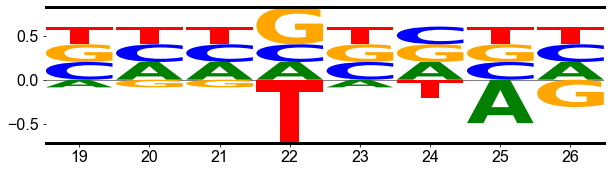

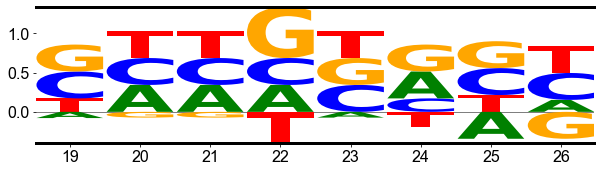

In [744]:
# pick -10

good = JAP[(JAP['J AR m'] > 20) | (JAP['J off m'] < 400)]
bad = JAP[(JAP['J AR m'] <= 5) | (JAP['J off m'] > 5000)]

a = pd.DataFrame((np.sum(np.stack(JAP['ohe_seq']),0)), columns = ['A','C','G','T'])
a = logomaker.transform_matrix(a,from_type='counts', to_type='probability')
g = pd.DataFrame((np.sum(np.stack(good['ohe_seq']),0)), columns = ['A','C','G','T'])
g = logomaker.transform_matrix(g,from_type='counts', to_type='probability')
b = pd.DataFrame((np.sum(np.stack(bad['ohe_seq']),0)), columns = ['A','C','G','T'])
b = logomaker.transform_matrix(b,from_type='counts', to_type='probability')

# logo = logomaker.Logo(p,stack_order='small_on_top', fade_probabilities=True)

logo = logomaker.Logo((np.log(g/b)).iloc[-8:], flip_below = False)
logo.style_spines(spines=['left', 'right'], visible=False)

logo = logomaker.Logo(((g-b)/a).iloc[-8:], flip_below = False)
logo.style_spines(spines=['left', 'right'], visible=False)


In [733]:
background = JAP[(JAP['J off m'] < 400) | (JAP['J AR m'] > 20)]
background = pd.DataFrame((np.sum(np.stack(background['ohe_seq']),0)), columns = ['A','C','G','T'])
background = logomaker.transform_matrix(background,from_type='counts', to_type='probability')
background

,A,C,G,T
pos,,,,
0,0.111111,0.111111,0.111111,0.666667
1,0.111111,0.111111,0.444444,0.333333
2,0.666667,0.111111,0.111111,0.111111
3,0.111111,0.333333,0.111111,0.444444
4,0.444444,0.111111,0.333333,0.111111
5,0.111111,0.111111,0.666667,0.111111
6,0.111111,0.666667,0.111111,0.111111
7,0.111111,0.111111,0.111111,0.666667
8,0.666667,0.111111,0.111111,0.111111


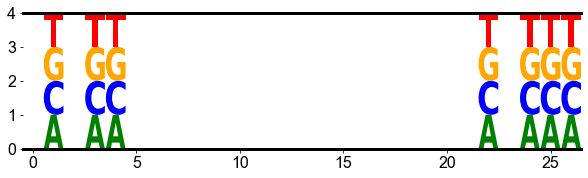

In [735]:
background = JAP[(JAP['J off m'] < 400) | (JAP['J AR m'] > 20)]
background = pd.DataFrame((np.sum(np.stack(background['ohe_seq']),0)), columns = ['A','C','G','T'])
background = logomaker.transform_matrix(background,from_type='counts', to_type='probability')

top = (background>0.6)
bot = (background<0.6).all(1)
background[:] = 0

background[bot] = 1
background[top] = 0
logo = logomaker.Logo((background), flip_below = False)
logo.style_spines(spines=['left', 'right'], visible=False)

In [656]:
JAP[JAP.index.map(lambda i: JAP.loc[i]['seq'][3] == 'C')]

,J off m,J on m,J AR m,seq,ohe_seq
J23109,185.683405,249.081809,1.341433,TTACAGCTAGCTCAGTCCTAGGGACTG,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [..."
J23117,390.127515,13996.883400,35.877714,TGACAGCTAGCTCAGTCCTAGGGATTG,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0], [..."
J23108,2925.301270,15255.263900,5.214938,TGACAGCTAGCTCAGTCCTAGGTATAA,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0], [..."
J23105,3755.802750,25883.885900,6.891705,TTACGGCTAGCTCAGTCCTAGGTACTA,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [..."
J23107,4481.321130,23427.149400,5.227733,TTACGGCTAGCTCAGCCCTAGGTATTA,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [..."
J23106,6004.428500,24739.271400,4.120171,TTACGGCTAGCTCAGTCCTAGGTATAG,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [..."
J23110,8271.304380,25655.846300,3.101790,TTACGGCTAGCTCAGTCCTAGGTACAA,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [..."
J23118,15853.452900,27187.298800,1.714913,TGACGGCTAGCTCAGTCCTAGGTATTG,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0], [..."
J23111,20157.985100,21541.077600,1.068613,TGACGGCTAGCTCAGTCCTAGGTATAG,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0], [..."


In [657]:
JAP[JAP.index.map(lambda i: JAP.loc[i]['seq'][3] == 'T')]

,J off m,J on m,J AR m,seq,ohe_seq
J23113,210.830833,104.098588,0.493754,TGATGGCTAGCTCAGTCCTAGGGATTA,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0], [..."
J23112,210.928365,106.684543,0.505786,TGATAGCTAGCTCAGTCCTAGGGATTA,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0], [..."
J23114,751.331572,17893.957900,23.816326,TTATGGCTAGCTCAGTCCTAGGTACAA,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [..."
J23115,1354.925350,20930.249700,15.447530,TTATAGCTAGCTCAGCCCTTGGTACAA,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [..."


In [723]:
background = JAP[(JAP['J AR m'] >= 5)].copy()
background = pd.DataFrame((np.sum(np.stack(background['ohe_seq']),0)), columns = ['A','C','G','T'])
background = logomaker.transform_matrix(background,from_type='counts', to_type='probability')

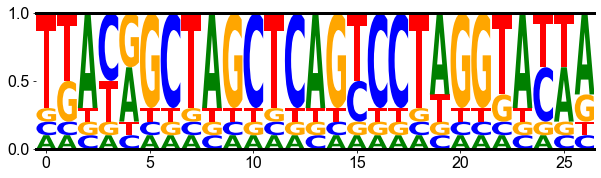

In [724]:
logo = logomaker.Logo((background), flip_below = False)
logo.style_spines(spines=['left', 'right'], visible=False)

In [730]:
JAP[(JAP['J off m'] < 400) | (JAP['J AR m'] > 20)]

,J off m,J on m,J AR m,seq,ohe_seq
J23109,185.683405,249.081809,1.341433,TTACAGCTAGCTCAGTCCTAGGGACTG,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [..."
J23113,210.830833,104.098588,0.493754,TGATGGCTAGCTCAGTCCTAGGGATTA,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0], [..."
J23112,210.928365,106.684543,0.505786,TGATAGCTAGCTCAGTCCTAGGGATTA,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0], [..."
J23117,390.127515,13996.883400,35.877714,TGACAGCTAGCTCAGTCCTAGGGATTG,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0], [..."
J23114,751.331572,17893.957900,23.816326,TTATGGCTAGCTCAGTCCTAGGTACAA,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [..."


In [729]:
JAP

,J off m,J on m,J AR m,seq,ohe_seq
J23109,185.683405,249.081809,1.341433,TTACAGCTAGCTCAGTCCTAGGGACTG,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [..."
J23113,210.830833,104.098588,0.493754,TGATGGCTAGCTCAGTCCTAGGGATTA,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0], [..."
J23112,210.928365,106.684543,0.505786,TGATAGCTAGCTCAGTCCTAGGGATTA,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0], [..."
J23117,390.127515,13996.883400,35.877714,TGACAGCTAGCTCAGTCCTAGGGATTG,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0], [..."
J23114,751.331572,17893.957900,23.816326,TTATGGCTAGCTCAGTCCTAGGTACAA,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [..."
J23115,1354.925350,20930.249700,15.447530,TTATAGCTAGCTCAGCCCTTGGTACAA,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [..."
J23108,2925.301270,15255.263900,5.214938,TGACAGCTAGCTCAGTCCTAGGTATAA,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0], [..."
J23105,3755.802750,25883.885900,6.891705,TTACGGCTAGCTCAGTCCTAGGTACTA,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [..."
J23107,4481.321130,23427.149400,5.227733,TTACGGCTAGCTCAGCCCTAGGTATTA,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [..."
J23106,6004.428500,24739.271400,4.120171,TTACGGCTAGCTCAGTCCTAGGTATAG,"[[0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1.0], [..."
